# **Automatic Speech Recognition**

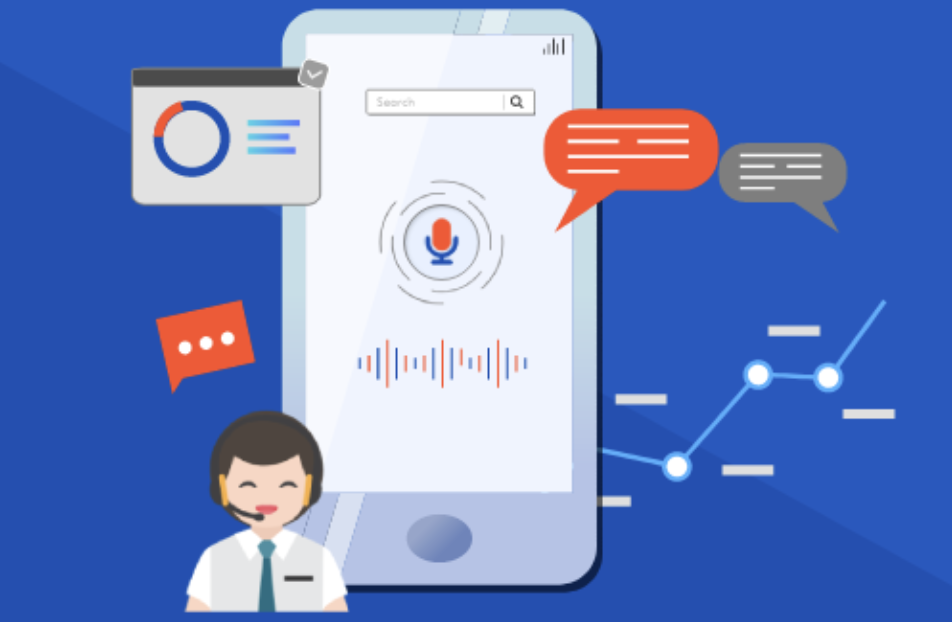

# **Overview**

Speech Recognition, also known as Automatic Speech Recognition (ASR), is a technology that converts spoken language into written text. It plays a crucial role in bridging the gap between human speech and computer understanding, enabling applications like virtual assistants, real-time transcription, and voice-controlled systems. ASR systems typically process audio signals by extracting features such as spectrograms, then using Artificial Intelligence-based model sto decode these signals into meaningful word sequences. In the context of natural language processing (NLP), ASR provides the first step in enabling machines to understand and respond to spoken language.

---

# **Dataset**

LibriSpeech is a widely used speech recognition dataset designed for training and evaluating automatic speech recognition (ASR) systems. It was introduced by Vassil Panayotov et al. in 2015 and has since become one of the standard benchmarks in the ASR research community.

LibriSpeech is a publicly available speech recognition dataset consisting of approximately 1,000 hours of English speech derived from audiobooks that are part of the LibriVox project. It was created to support training and evaluation of automatic speech recognition (ASR) systems. The audio is sampled at 16 kHz and is accompanied by accurate, time-aligned transcripts. LibriSpeech includes multiple subsets such as "train-clean," "train-other," "dev-clean," and "test-clean," allowing researchers to benchmark models under varying levels of audio quality and complexity. Its accessibility, size, and quality have made it one of the most widely used datasets in speech and NLP research.

---

***Note on Dataset Usage:***

The corresponding dataset used in this assignment is a subset of the LibriSpeech corpus and has been specifically selected and uploaded on Canvas. To ensure consistency in evaluation and reproducibility, you must not use any external data or download additional LibriSpeech files. Only use the audio and transcript files provided in the assignment folder on Canvas.

---

# **Step 1: Read the Audio Files**

Assume the corresponding dataset includes:

*   Several .flac audio files (e.g., 84-121123-0000.flac)
*   A transcript file (e.g., transcripts.txt)


**Question 1:** Using Whisper, load Audio and Transcribe.
In addition, can you  answer the following questions:

*   What is the sampling rate of the provided audio files, and why is it important for speech recognition?
*   What is the duration of each audio file?
*   What is the bit depth of the audio files, and how does it affect the quality of speech recognition?
*  What is the file size of each audio file, and how might the size relate to audio quality or length?
*   For each audio, plot it over time.
*   List item



For every question, be sure to anlayze and discuss your response.

Note: For answering this questions, python coding is needed. You can use libraries, such as librosa, or pydub.
For more information, please refer to:

**Librosa**: https://librosa.org/doc/latest/index.html

**pydub:** https://github.com/jiaaro/pydub


You can refer to tutorials at:

https://youtu.be/B31RiiRt_TE?si=76VKAir9xwG8hH2V

https://youtu.be/vJ_WL9aYfNI?si=Hx8OFbHfqJn07uQa

In [ ]:
# Core Speech to Text (for audio transcription)
!pip install openai-whisper
!pip install soundfile
!pip install librosa

# NLP Preprocessing
!pip install spacy
!python -m spacy download en_core_web_sm

# Evaluation Metrics
!pip install jiwer

# Text Cleaning and Language Utilities
!pip install pyspellchecker
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# File Handling & Utilities
import glob
import os
import re
import zipfile
from collections import Counter

# Audio Processing
import librosa
import librosa.display
import numpy as np
import soundfile as sf

# Visualization
import matplotlib.pyplot as plt

# Data Handling
import pandas as pd

# Speech to Text
import whisper

# NLP Preprocessing
import spacy
nlp = spacy.load("en_core_web_sm")

from spellchecker import SpellChecker
from langdetect import detect

# Evaluation Metrics
import jiwer
from jiwer import wer, cer, process_words, transforms

# Feature Extraction (Text)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

I aggregated all the import and installs here for better readability and ease of use to understand what all libraries went behind the analysis and avoid redundancy.

---

In [ ]:
# Extracting from Zip File
zip_path = "127105-1-1.zip"
extract_dir = "data"

# Extracting only once (prevents re-extraction)
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

print("Extraction completed.\nFolder structure:")
for root, dirs, files in os.walk(extract_dir):
    print(root)
    break

Extraction completed.
Folder structure:
data


Extracting Zip file using python's built in library. This code checks whether the target directory already exists before unzipping. This ensures the notebook remains clean, reproducible, and efficient when re-executed.

In [ ]:
# Finding all FLAC files in extracted folder
audio_files = sorted(
    glob.glob(os.path.join(extract_dir, "**", "*.flac"), recursive=True)
)

print(f"Found {len(audio_files)} audio files.")
audio_files[:5]

Found 37 audio files.


['data/127105/121-127105-0000.flac',
 'data/127105/121-127105-0001.flac',
 'data/127105/121-127105-0002.flac',
 'data/127105/121-127105-0003.flac',
 'data/127105/121-127105-0004.flac']

Finding all the **.flac** extension files as we know the zip consists of audio files in that format and displaying the names of the first 5.

### **Observations**
- 37 audio files where found.

In [ ]:
# Computing Audio Metadata

# Defining Function (I converted soundfile to intege bit depth)
def infer_bit_depth(subtype: str):
    if "PCM_" in subtype:
        try:
            return int(subtype.split("_")[1])
        except:
            return None
    return None

# Applying Function
metadata = []

for path in audio_files:
    info = sf.info(path)

    samplerate = info.samplerate
    frames = info.frames
    duration_sec = frames / samplerate
    subtype = info.subtype
    bit_depth = infer_bit_depth(subtype)
    file_size_bytes = os.path.getsize(path)

    utt_id = os.path.splitext(os.path.basename(path))[0]

    metadata.append(
        {
            "utt_id": utt_id,
            "path": path,
            "samplerate_Hz": samplerate,
            "duration_sec": duration_sec,
            "frames": frames,
            "subtype": subtype,
            "bit_depth": bit_depth,
            "file_size_bytes": file_size_bytes,
        }
    )

meta_df = pd.DataFrame(metadata)
meta_df

# Summary
print("Unique sampling rates:", meta_df["samplerate_Hz"].unique())
print("Average duration (sec):", meta_df["duration_sec"].mean())
print("Average file size (KB):", meta_df["file_size_bytes"].mean() / 1024)
print("\nStatistical Summary:")
print(meta_df[["samplerate_Hz", "duration_sec", "bit_depth"]].describe())

Unique sampling rates: [16000]
Average duration (sec): 6.262027027027026
Average file size (KB): 115.67828864020271

Statistical Summary:
       samplerate_Hz  duration_sec  bit_depth
count           37.0     37.000000       37.0
mean         16000.0      6.262027       16.0
std              0.0      4.143566        0.0
min          16000.0      2.000000       16.0
25%          16000.0      2.770000       16.0
50%          16000.0      5.075000       16.0
75%          16000.0      7.530000       16.0
max          16000.0     16.065000       16.0


In [ ]:
# Creating a clean metadata table
audio_table = meta_df[["utt_id", "duration_sec", "bit_depth", "file_size_bytes"]].copy()

# Converting file size to KB as observed by me
audio_table["file_size_KB"] = (audio_table["file_size_bytes"] / 1024).round(2)

# Dropping raw bytes column for readability
audio_table = audio_table.drop(columns=["file_size_bytes"])

# Renaming columns for clarity
audio_table = audio_table.rename(columns={
    "utt_id": "Utterance ID",
    "duration_sec": "Duration (sec)",
    "bit_depth": "Bit Depth",
    "file_size_KB": "File Size (KB)"
})

# Visualizing
audio_table

Utterance ID  Duration (sec)  Bit Depth  File Size (KB)
0   121-127105-0000           9.875         16          177.60
1   121-127105-0001           5.025         16          102.02
2   121-127105-0002           7.495         16          142.21
3   121-127105-0003           7.725         16          137.91
4   121-127105-0004           2.110         16           34.21
5   121-127105-0005           5.820         16          109.36
6   121-127105-0006           4.725         16           86.06
7   121-127105-0007           5.790         16          108.22
8   121-127105-0008           2.760         16           52.83
9   121-127105-0009           2.290         16           52.35
10  121-127105-0010           2.850         16           59.72
11  121-127105-0011           5.780         16          114.76
12  121-127105-0012           4.830         16           96.71
13  121-127105-0013           5.895         16          111.93
14  121-127105-0014           2.255         16           40.64
15  121-127105-0015           2.960         16           58.57
16  121-127105-0016           2.030         16           45.20
17  121-127105-0017           2.695         16           58.75
18  121-127105-0018           2.770         16           58.31
19  121-127105-0019           3.525         16           68.95
20  121-127105-0020          14.355         16          272.83
21  121-127105-0021           2.000         16           45.56
22  121-127105-0022           5.075         16           88.84
23  121-127105-0023          10.910         16          209.78
24  121-127105-0024          14.450         16          268.38
25  121-127105-0025          16.065         16          301.52
26  121-127105-0026           7.530         16          143.75
27  121-127105-0027          13.870         16          257.05
28  121-127105-0028           6.750         16          124.62
29  121-127105-0029           7.310         16          133.57
30  121-127105-0030           2.175         16           42.41
31  121-127105-0031          10.765         16          173.29
32  121-127105-0032           3.170         16           62.91
33  121-127105-0033           2.355         16           43.00
34  121-127105-0034           7.410         16          119.96
35  121-127105-0035          14.150         16          205.99
36  121-127105-0036           4.150         16           70.33

### **Audio File Metadata Extraction**

- Here, I extracted important metadata from each **.flac** audio file provided in the dataset.  

- Each audio file was processed to compute:
  - **Sampling Rate (Hz)**  
  - **Duration (seconds)**  
  - **Total Frames**  
  - **Bit Depth**  
  - **File Size (bytes)**  
  - **Utterance ID (utt_id)** extracted from the filename

- All metadata entries were stored in a pandas DataFrame (**meta_df**) for analysis and later alignment with transcripts.

- To supplement the earlier summary statistics, I also generated a full metadata table for all audio files.This table includes the duration, bit depth, and file size (KB) for each utterance after extraction

### **Observations**
- **Sampling Rate:** All audio files use a **16 kHz** sampling rate, which is the standard for speech recognition datasets.
- **Bit Depth:** All files have a **16-bit depth**, meaning the recordings use standard PCM linear encoding with good dynamic range for speech.  
- **Average Duration:** The mean duration of the audio clips is **~6.26 seconds**, with lengths ranging from **2 seconds** to **16 seconds**.
- **Average File Size:** The average size is **~115 KB**.
- **No variation** in sampling rate or bit depth across files  
- Wide variation in **duration**, which is expected since each utterance represents differently sized spoken sentences

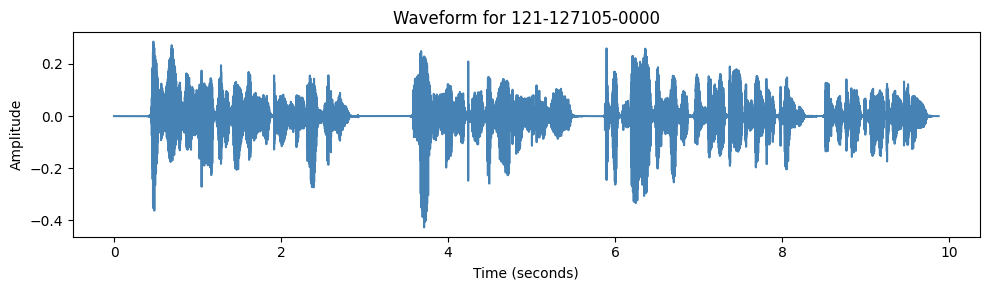

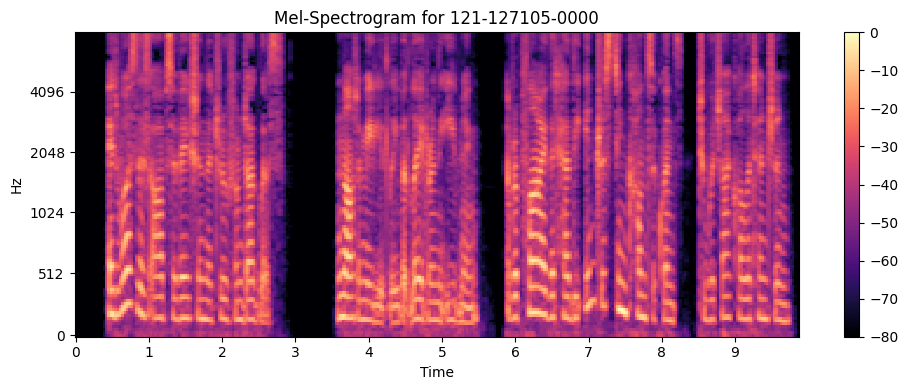

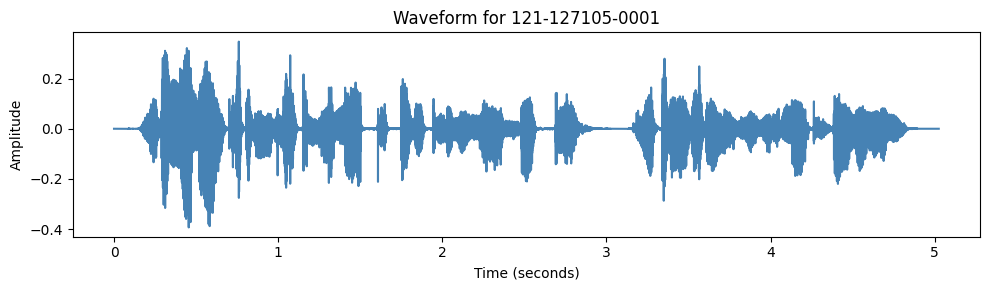

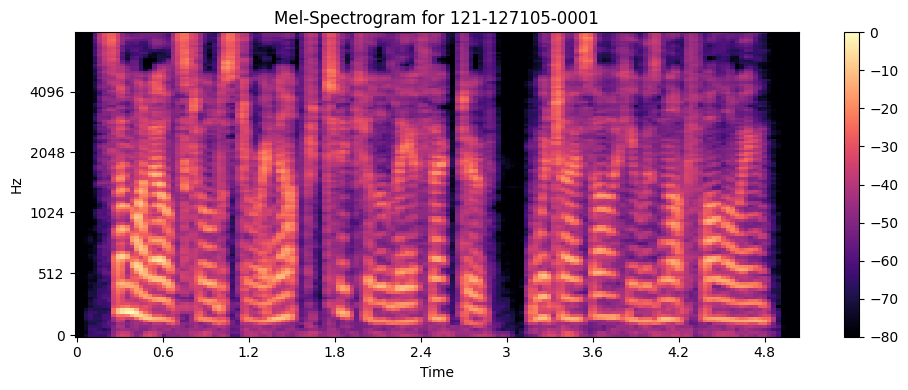

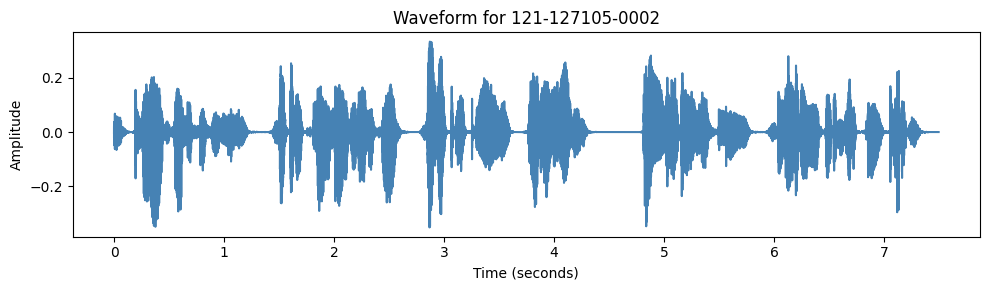

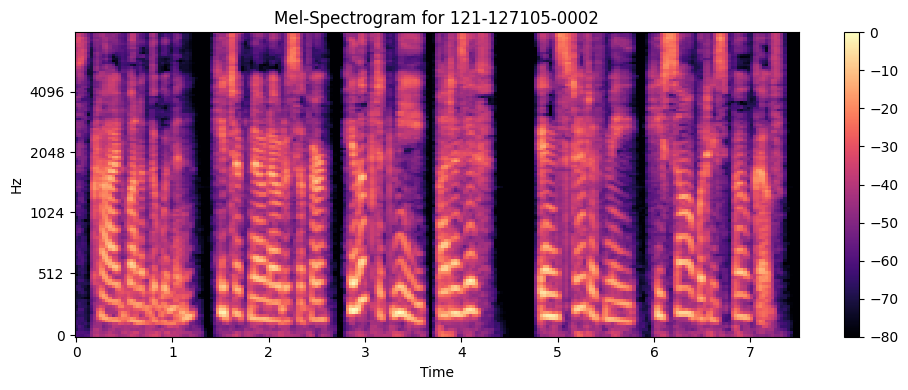

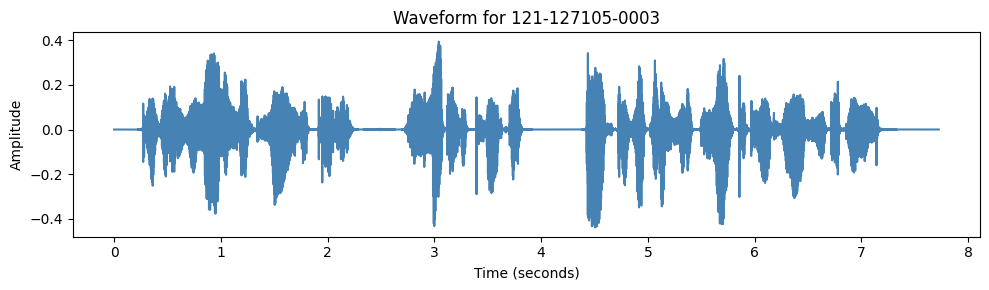

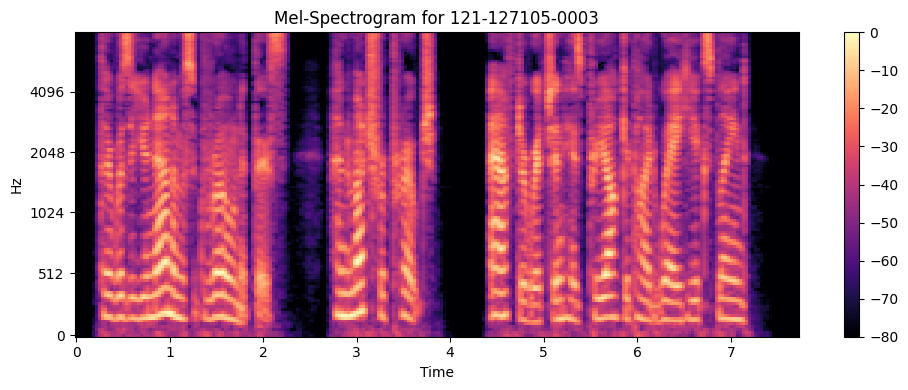

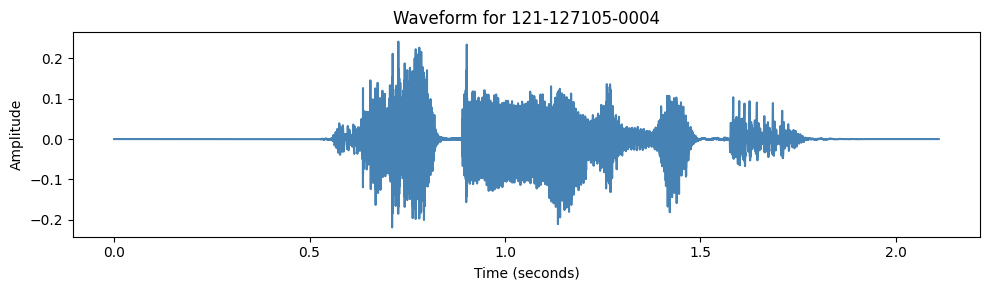

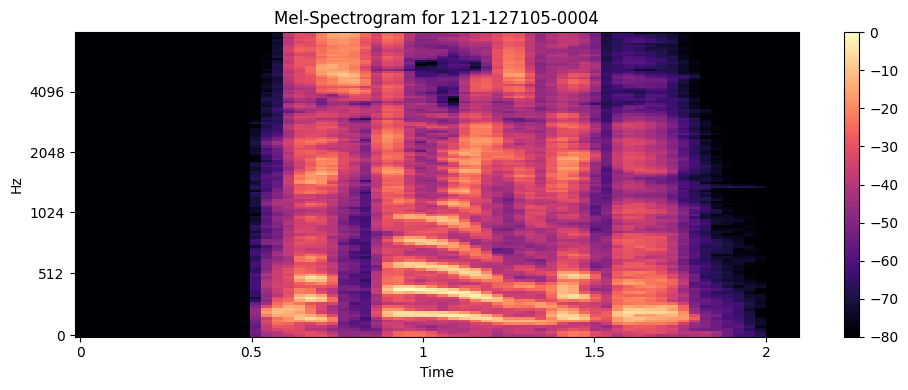

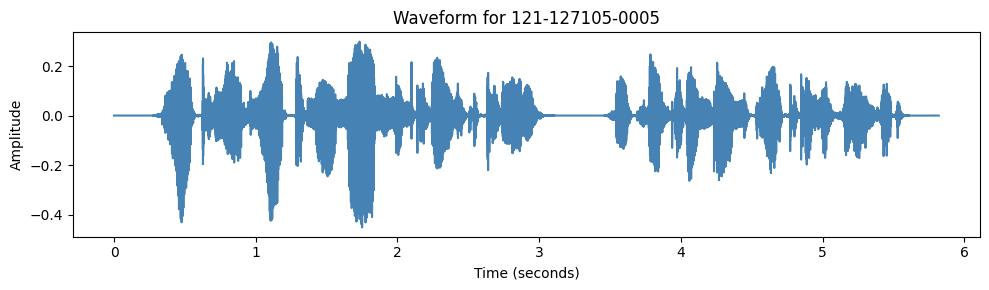

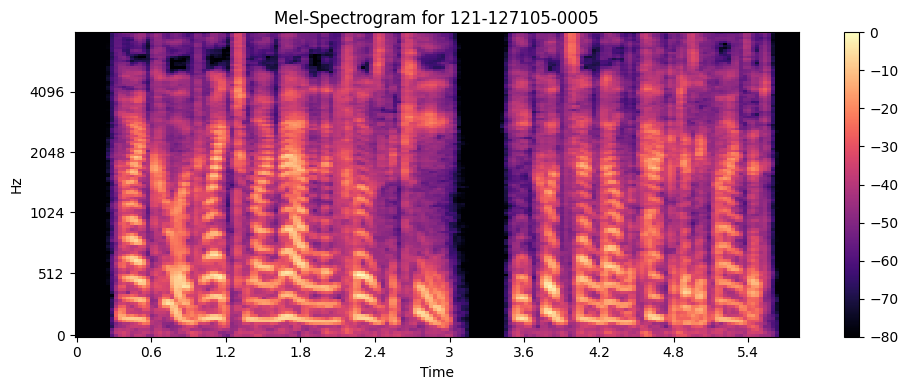

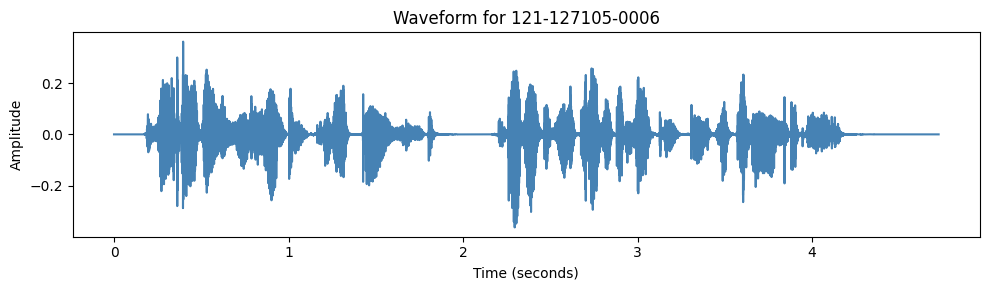

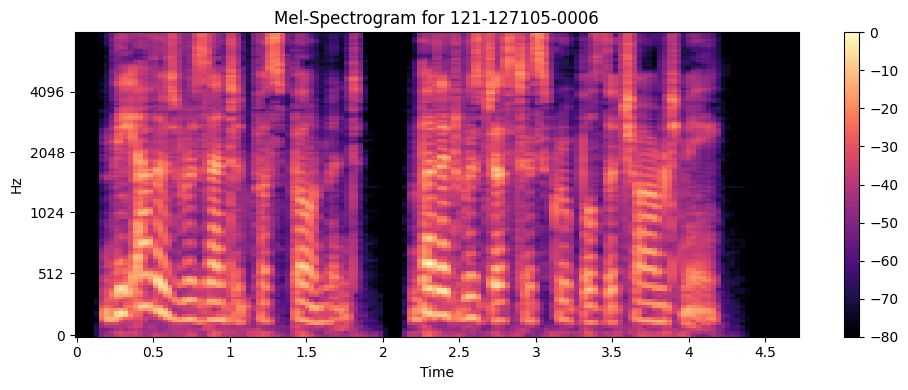

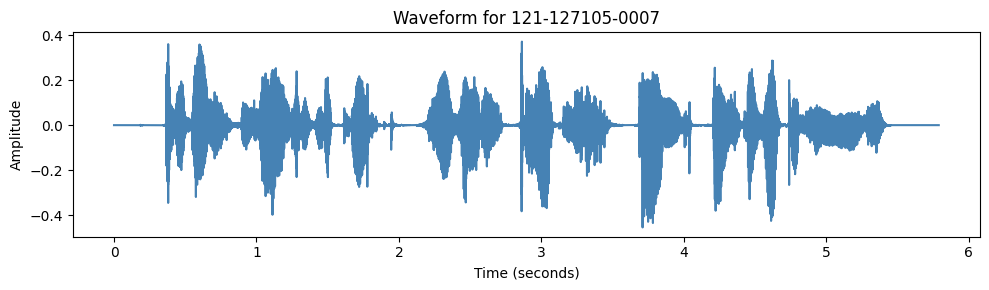

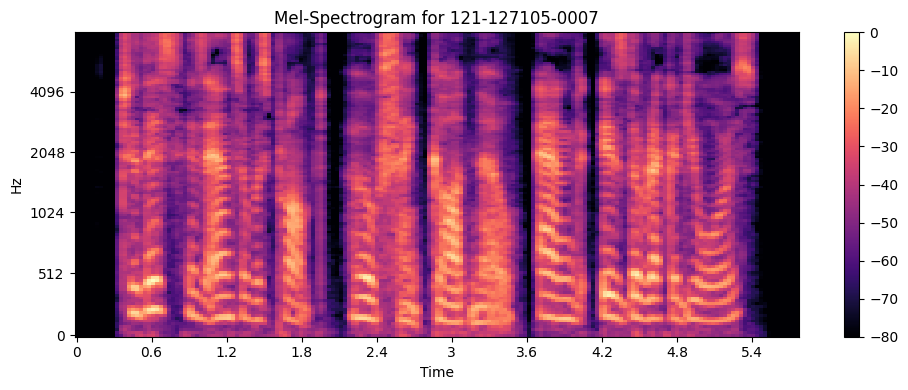

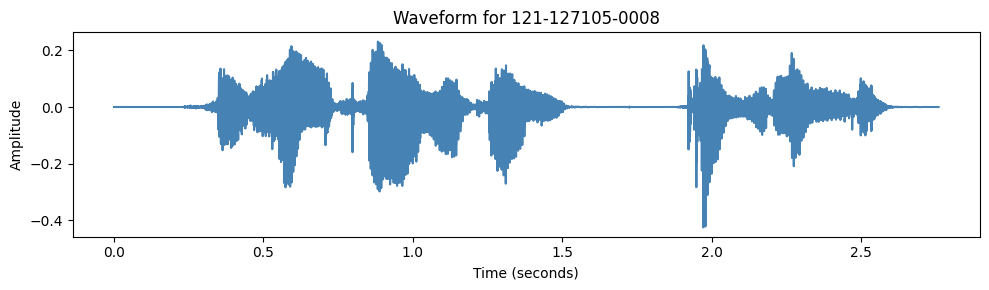

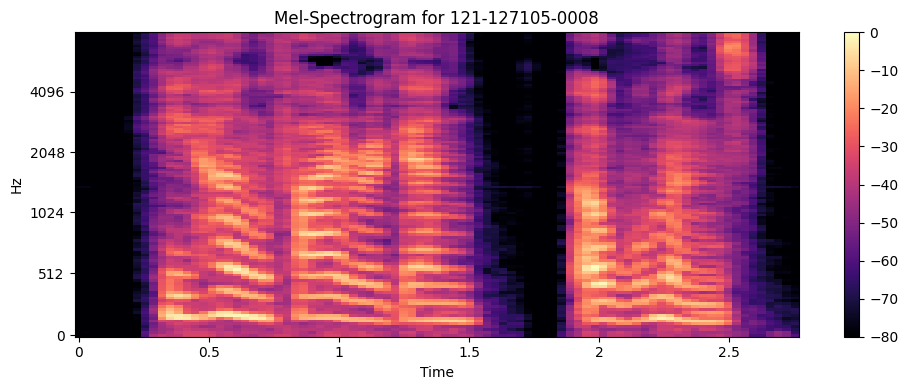

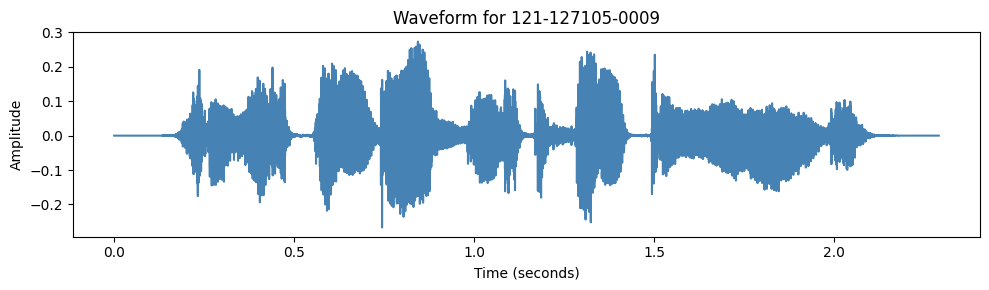

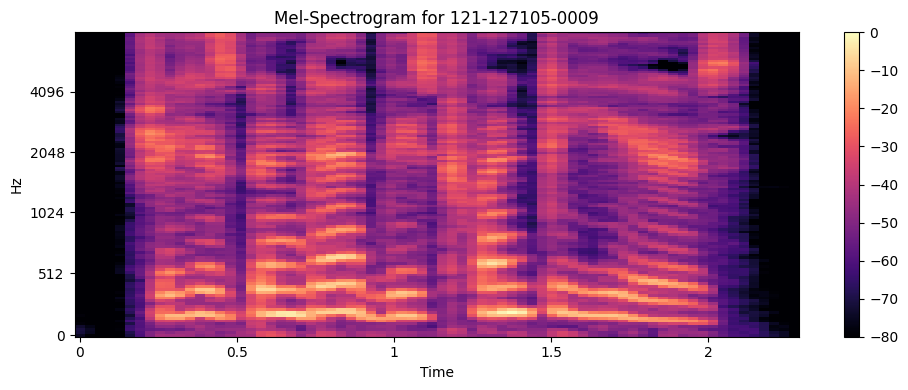

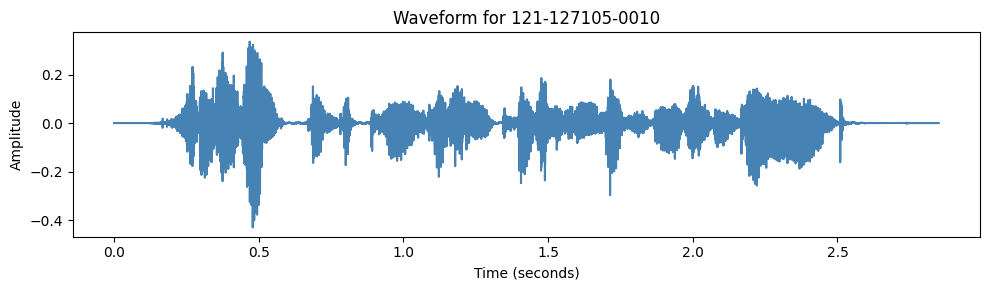

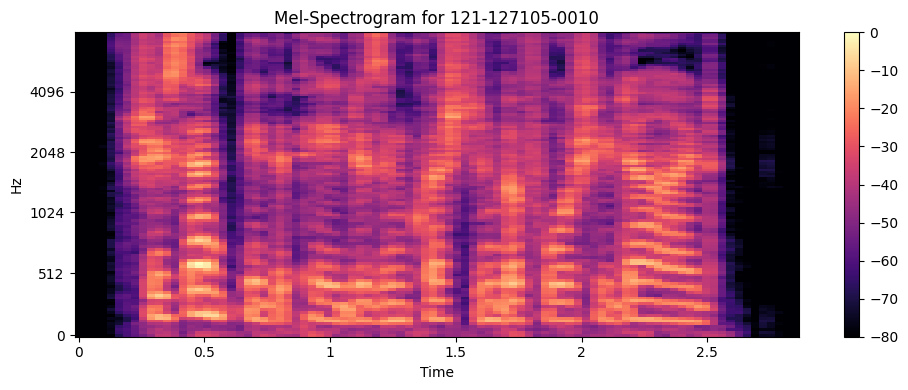

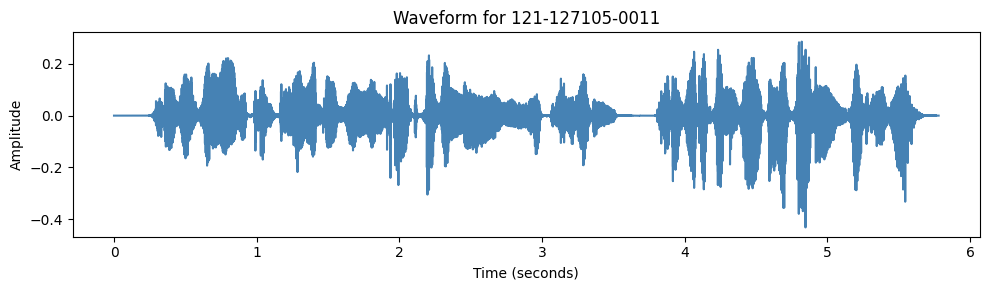

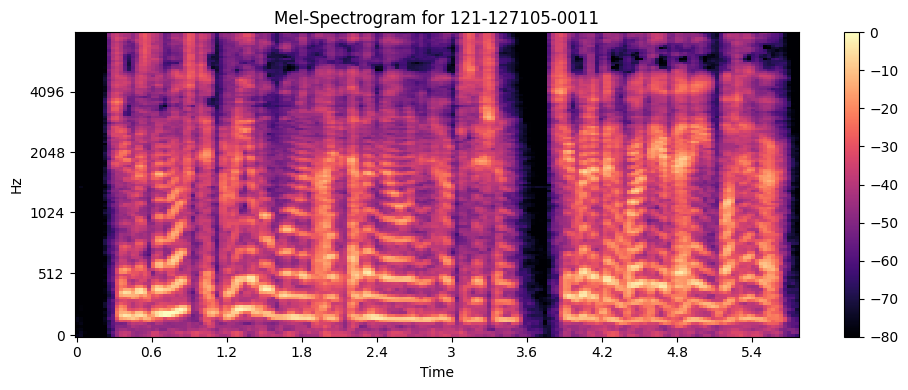

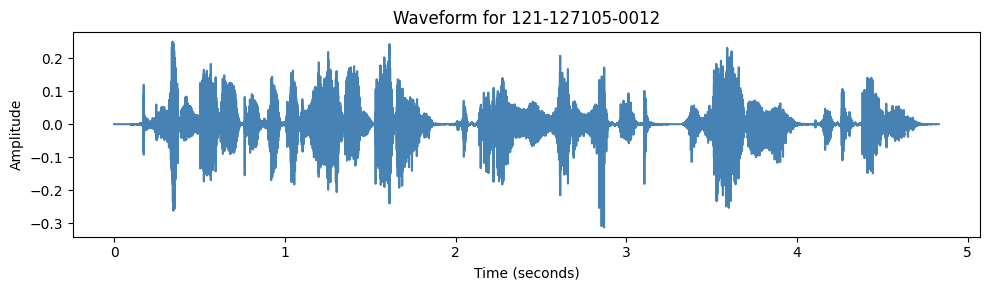

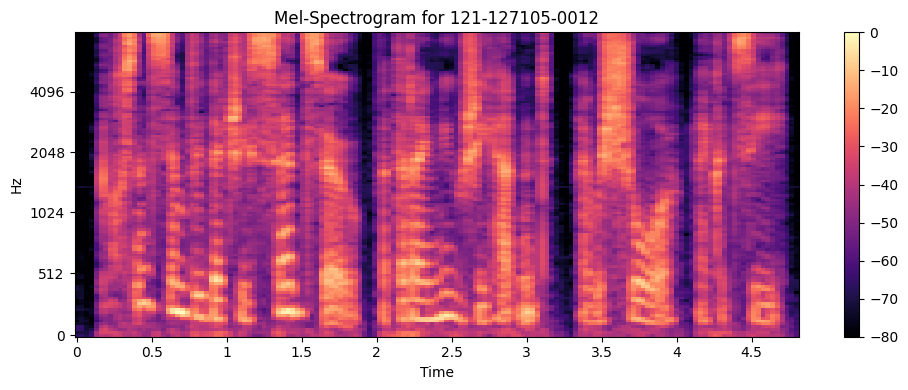

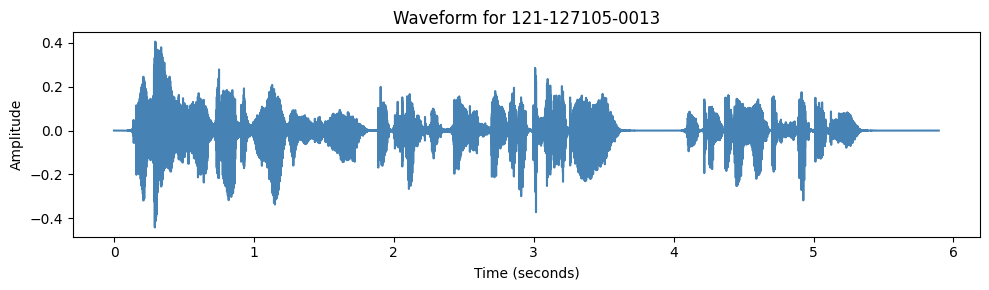

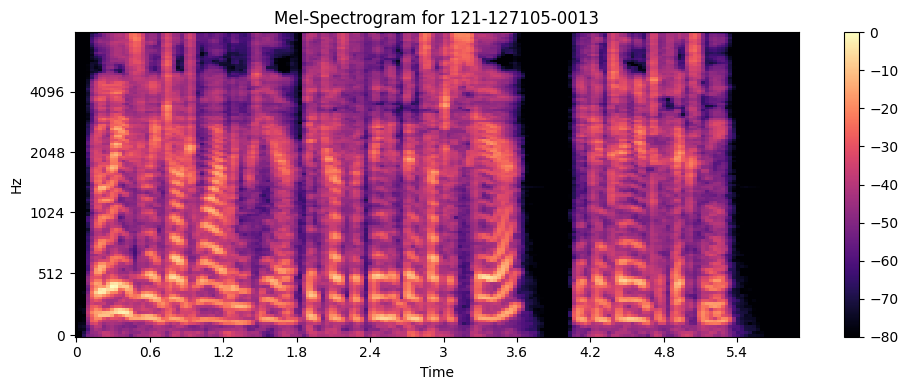

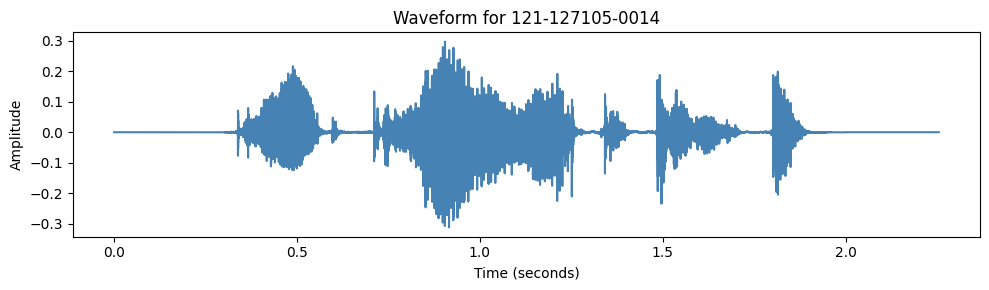

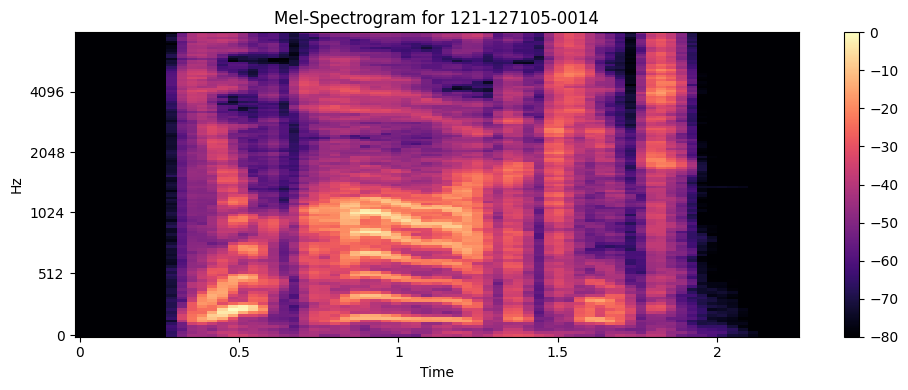

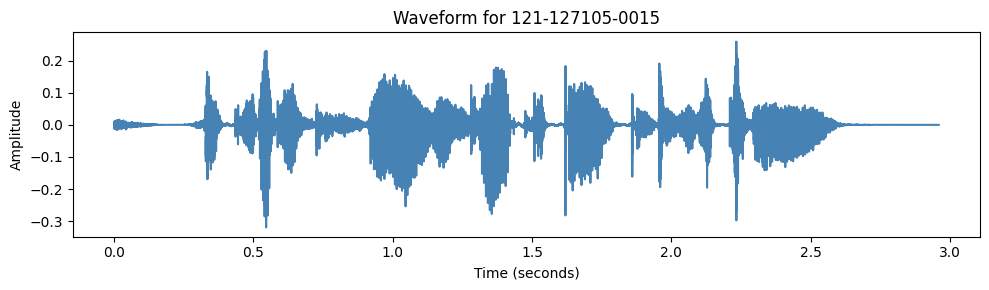

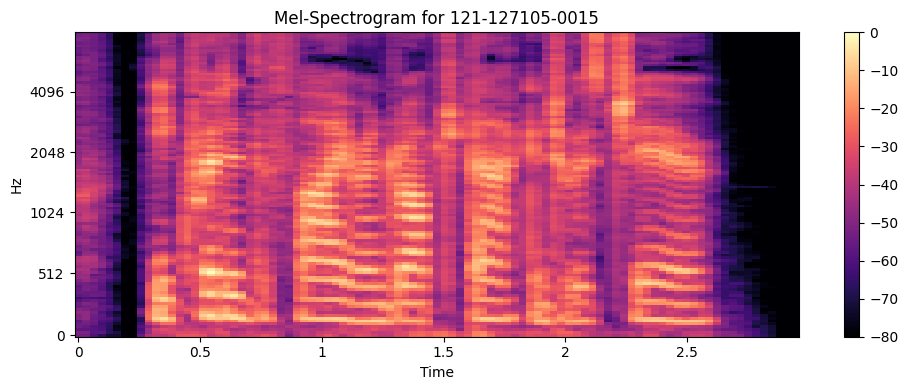

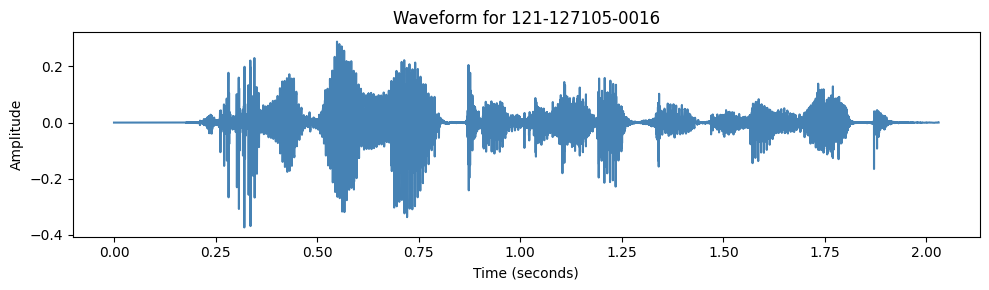

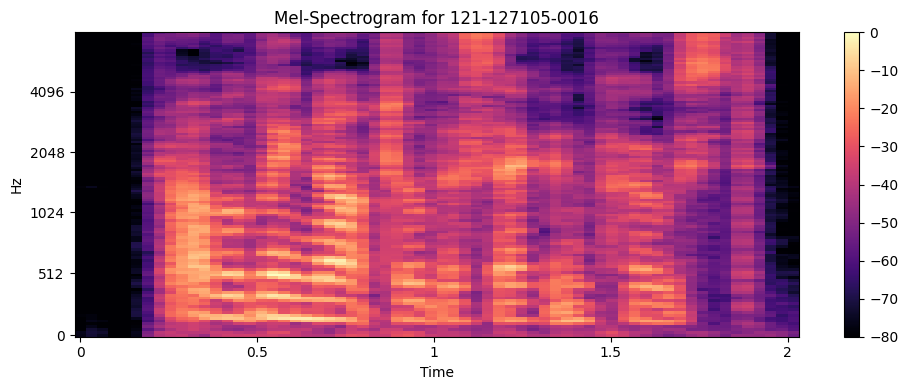

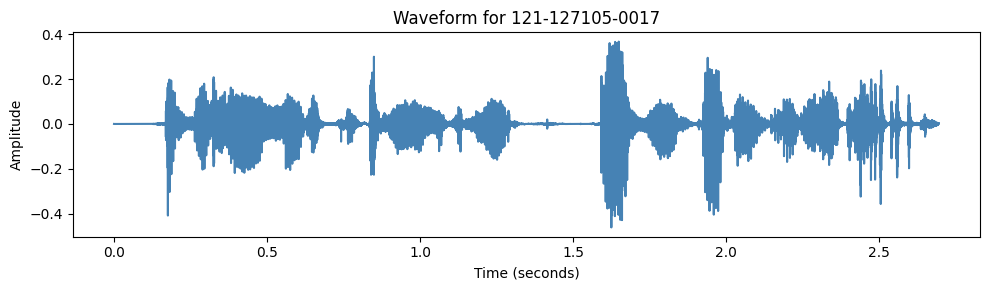

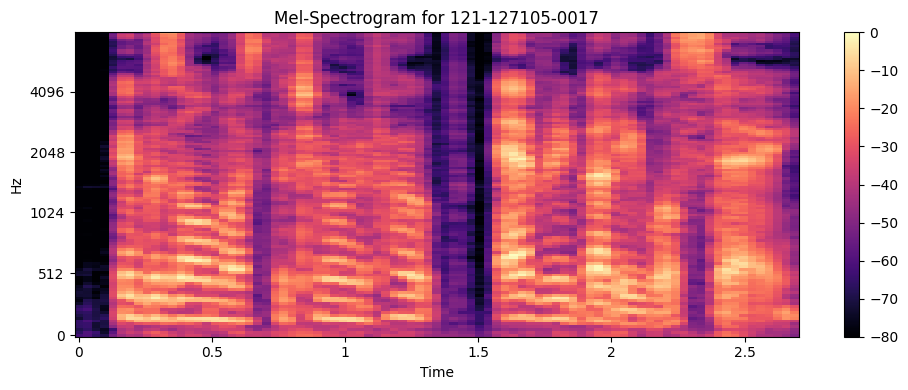

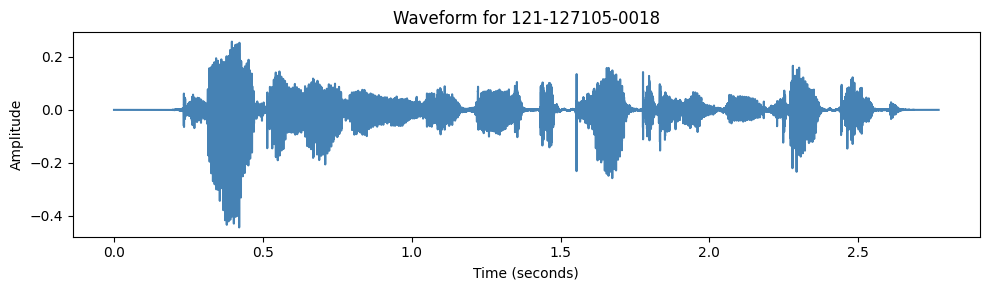

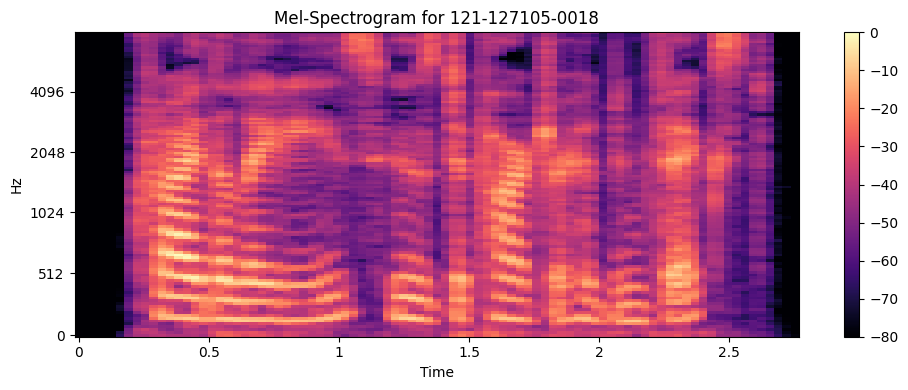

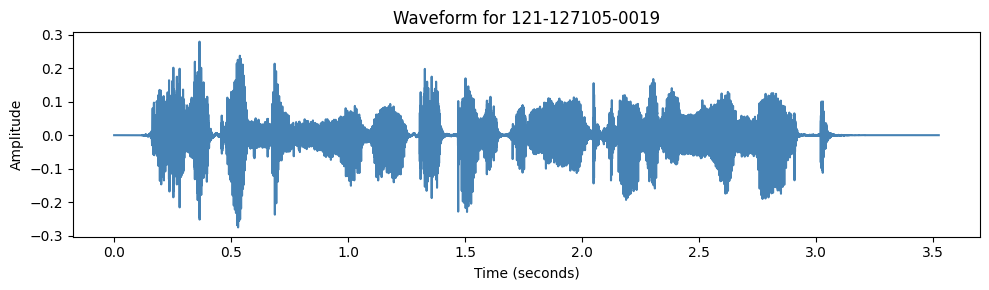

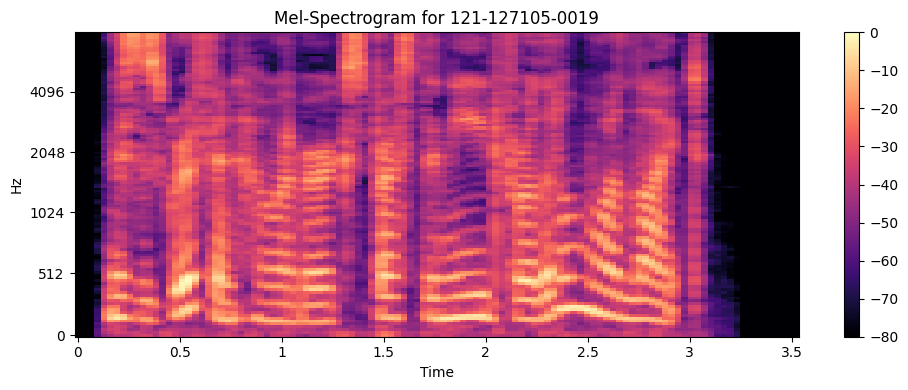

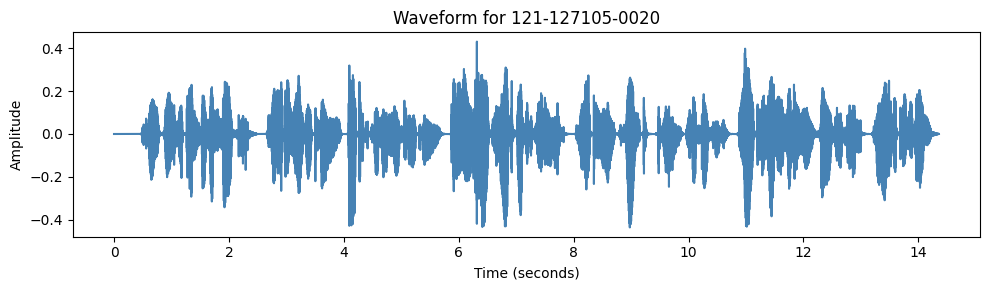

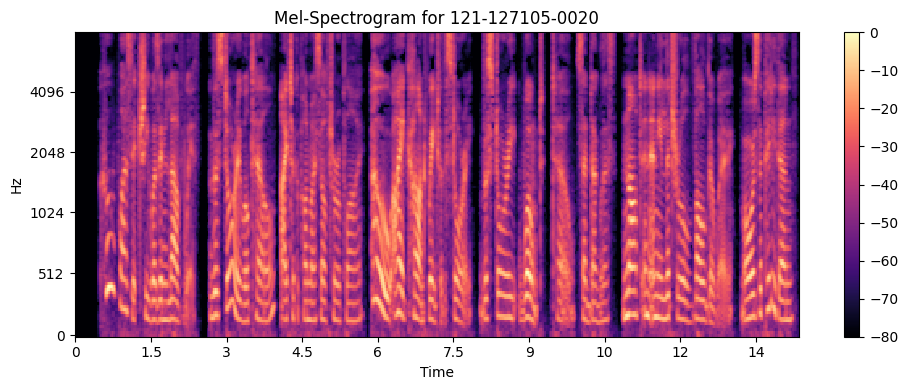

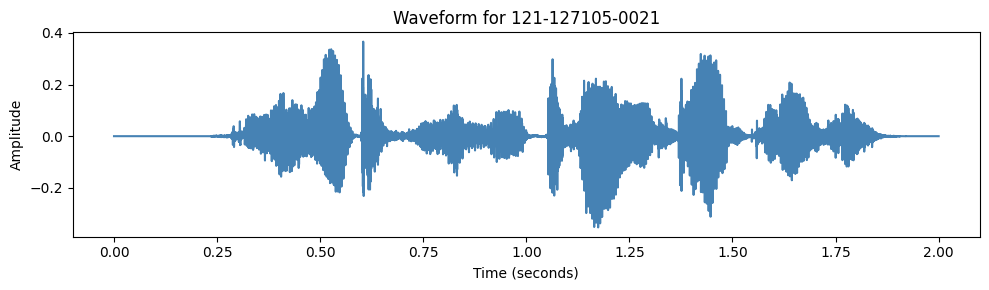

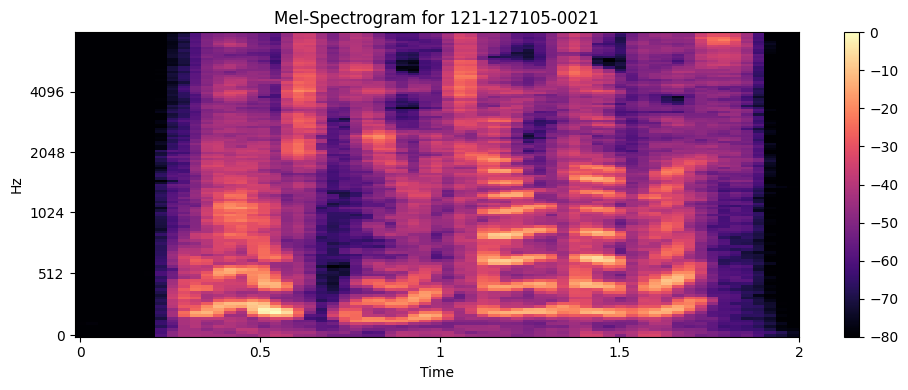

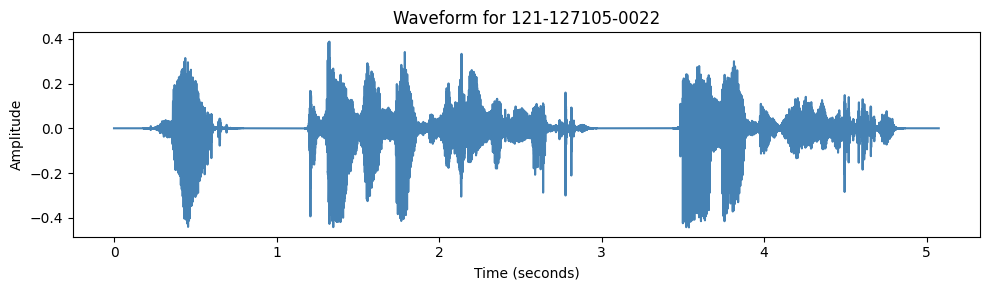

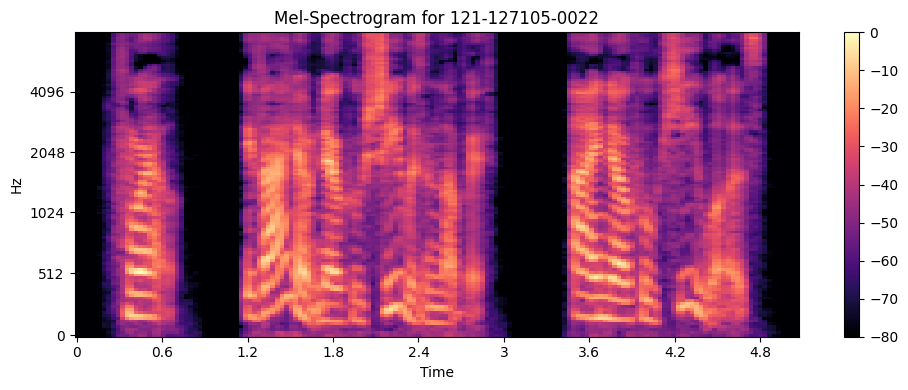

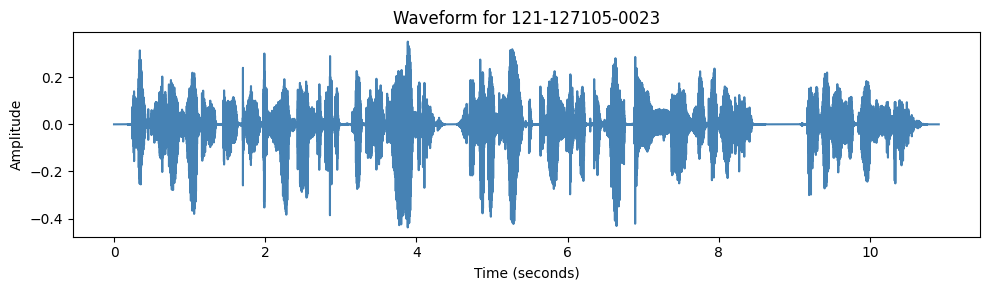

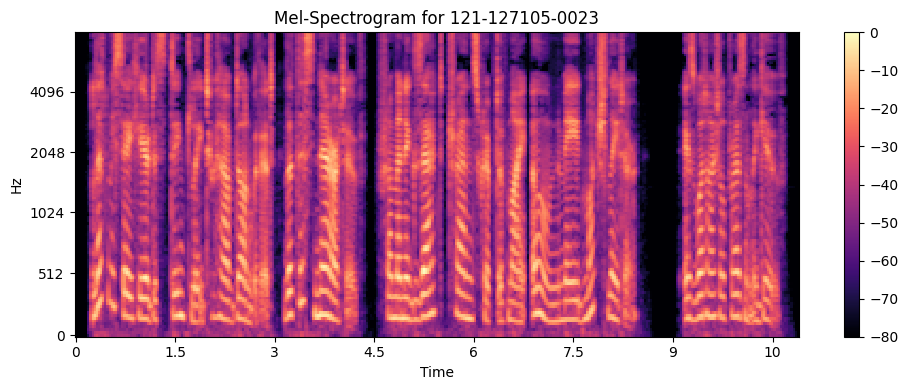

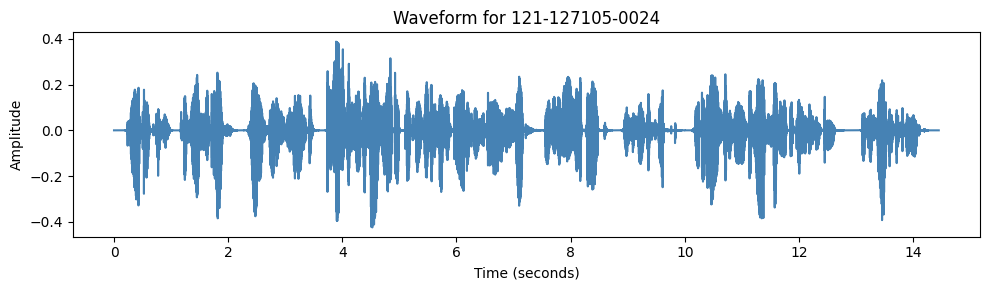

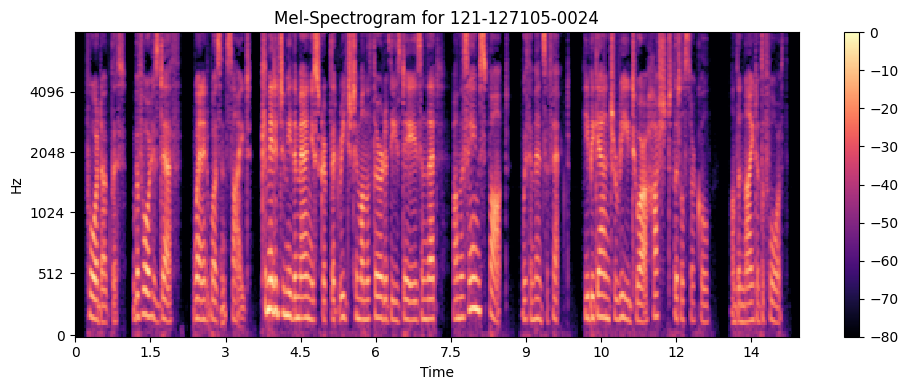

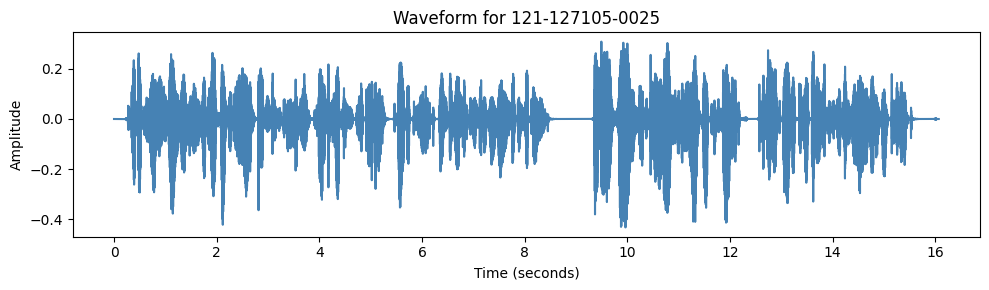

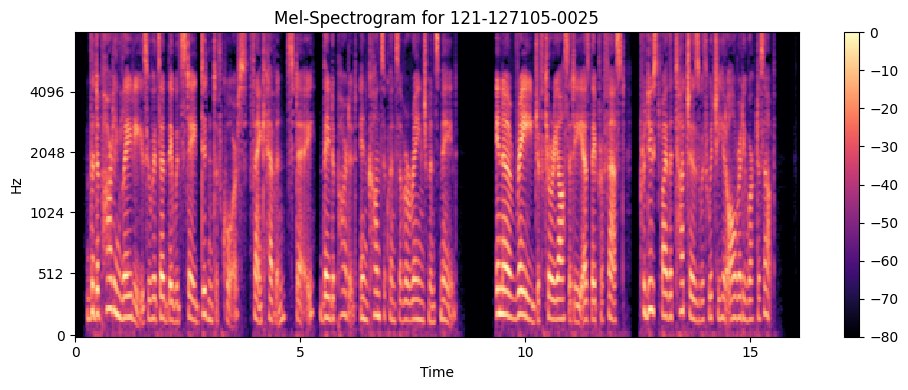

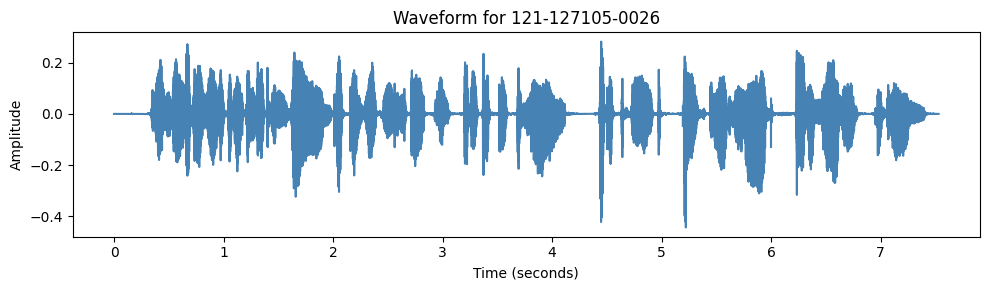

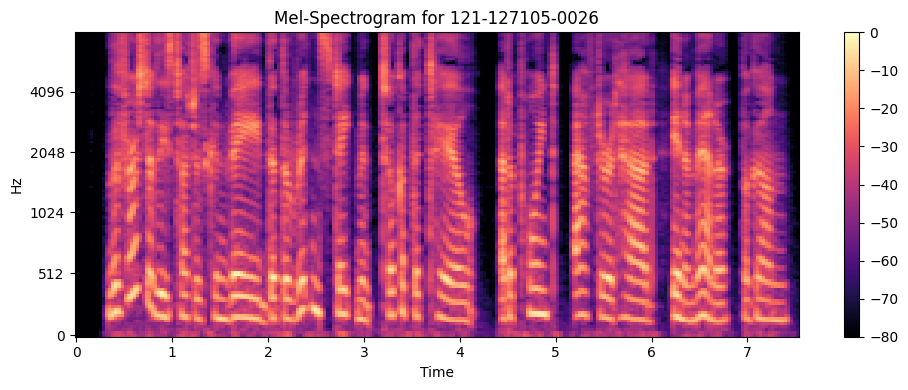

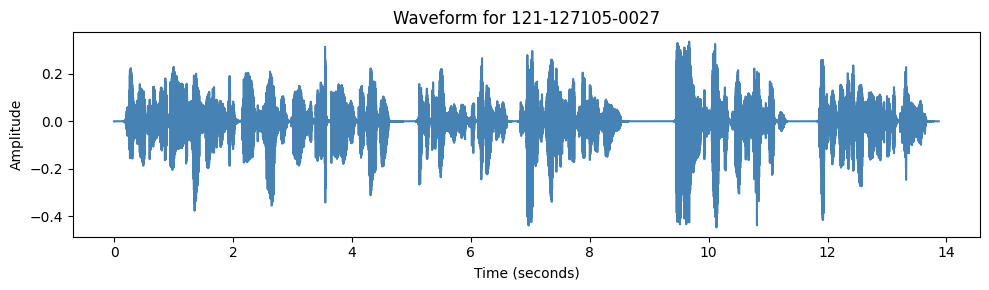

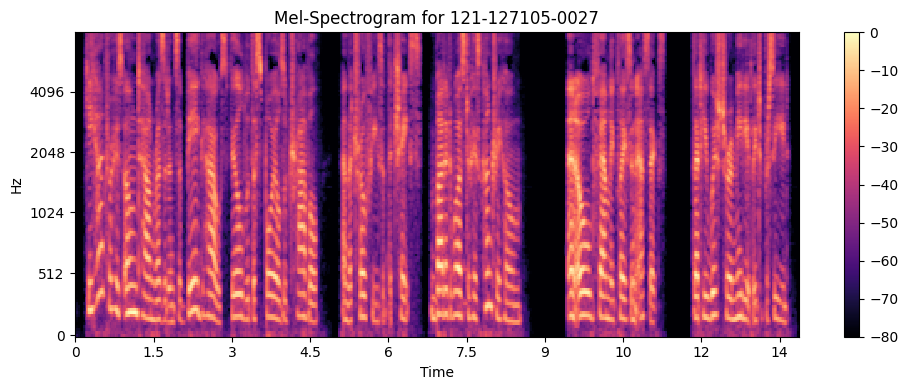

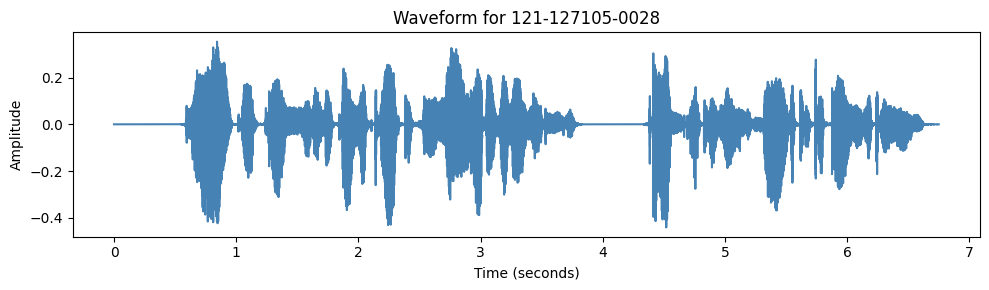

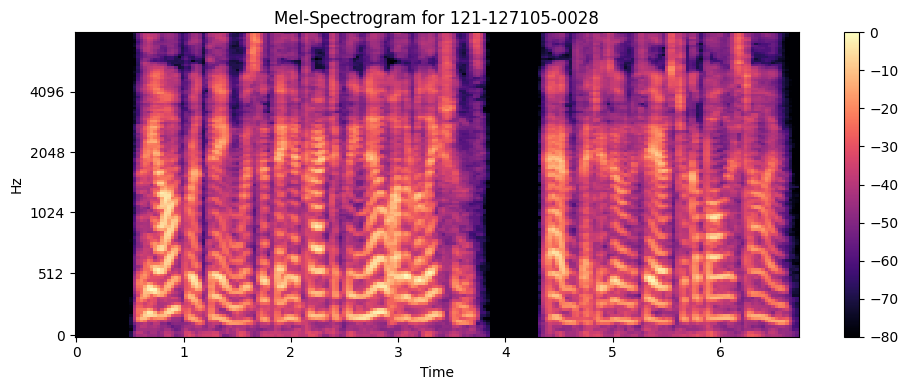

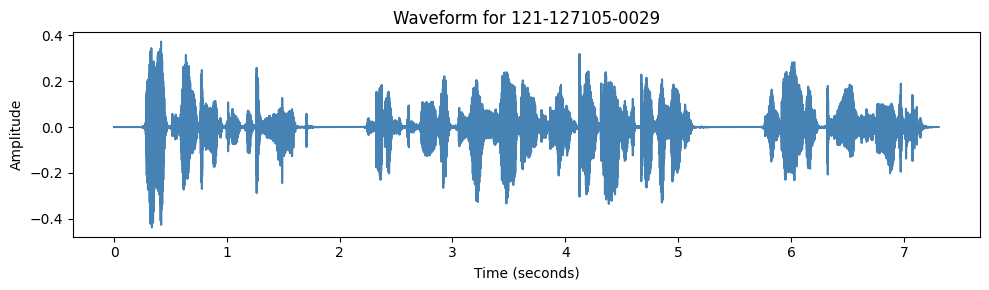

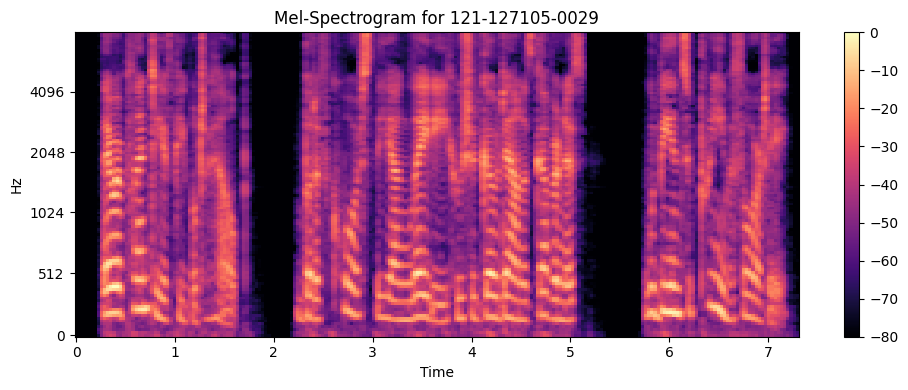

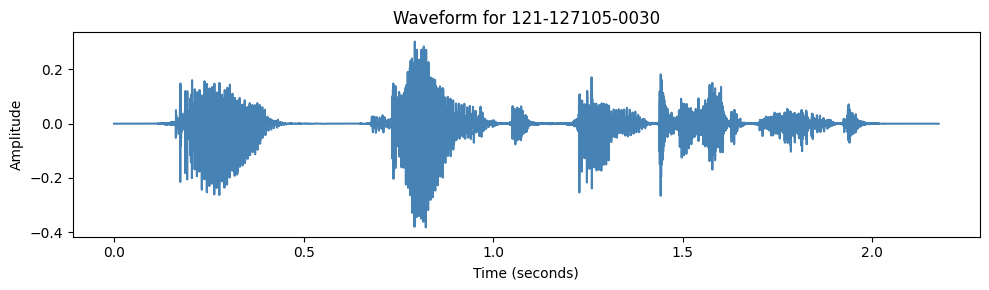

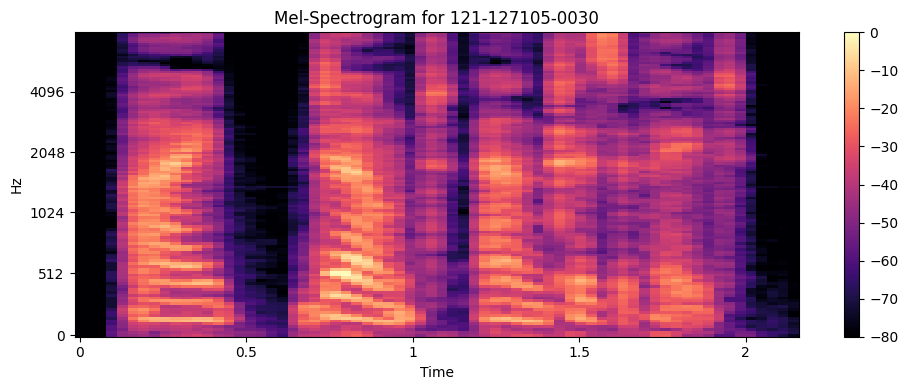

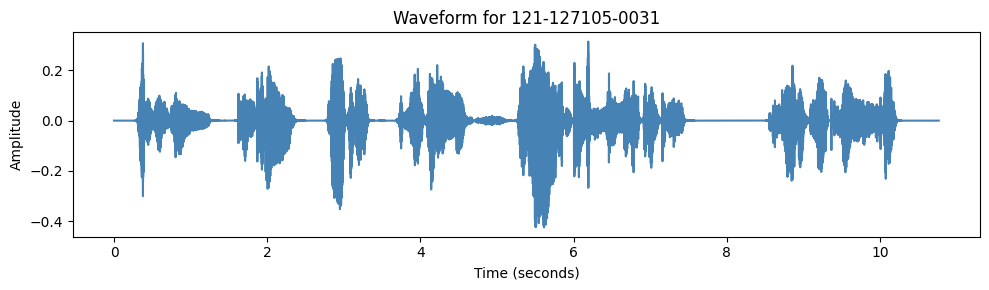

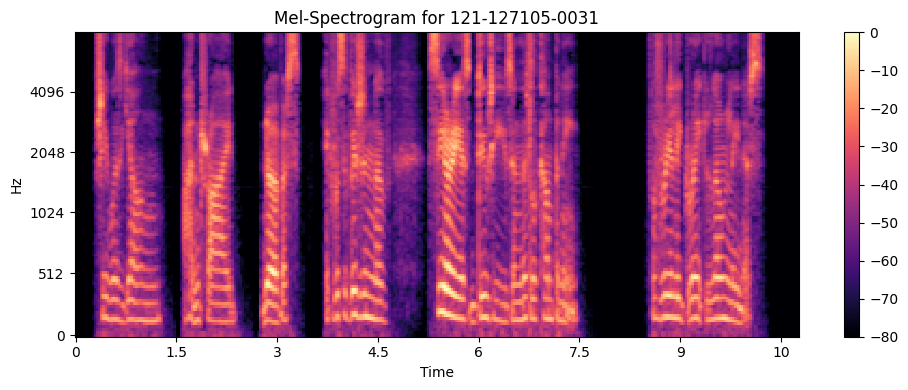

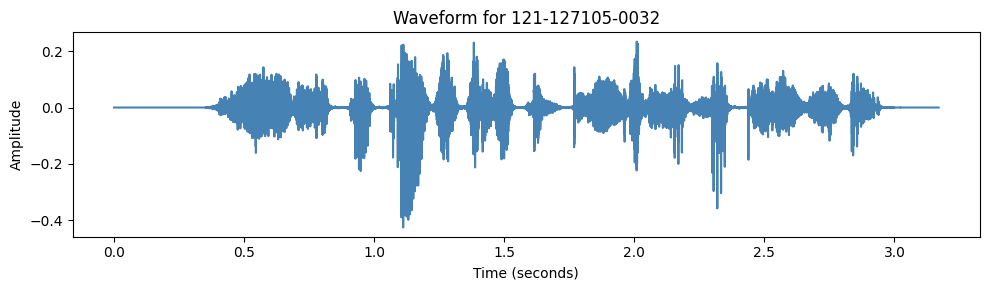

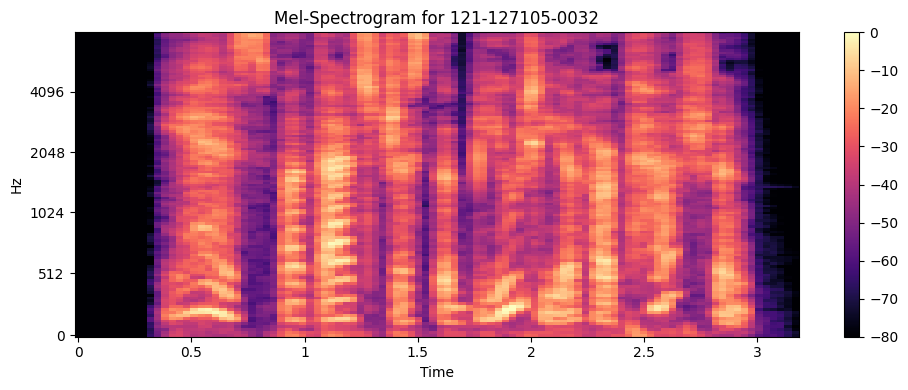

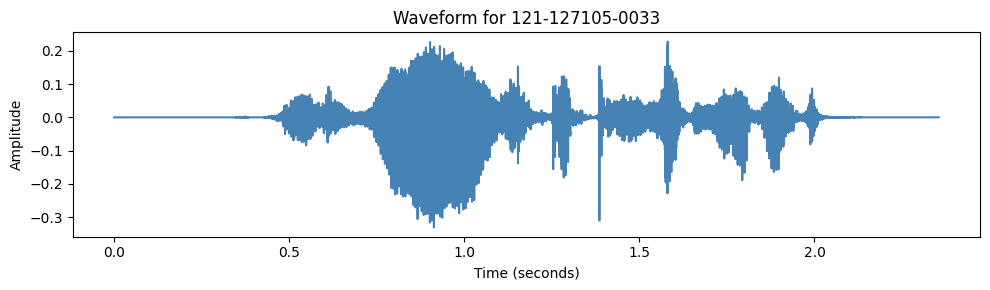

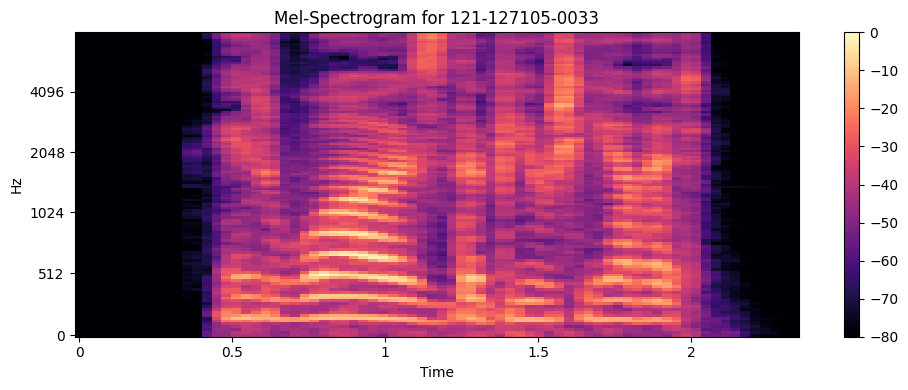

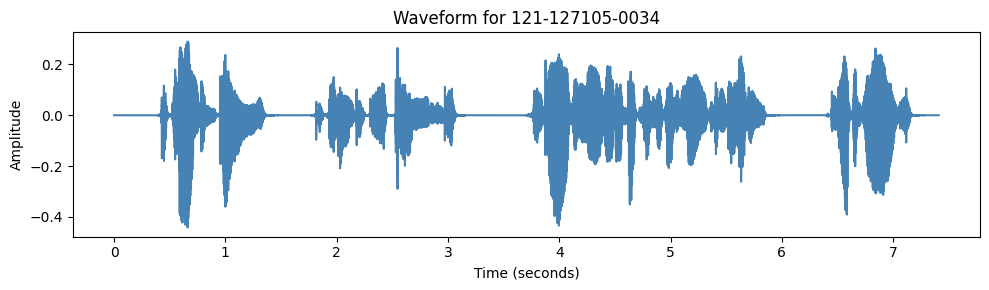

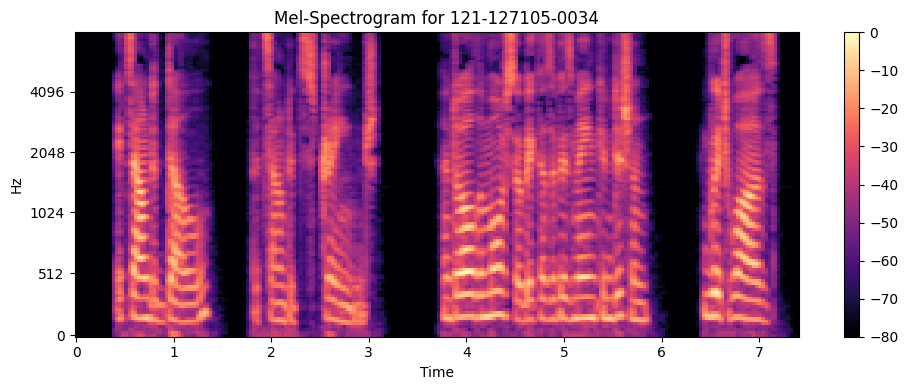

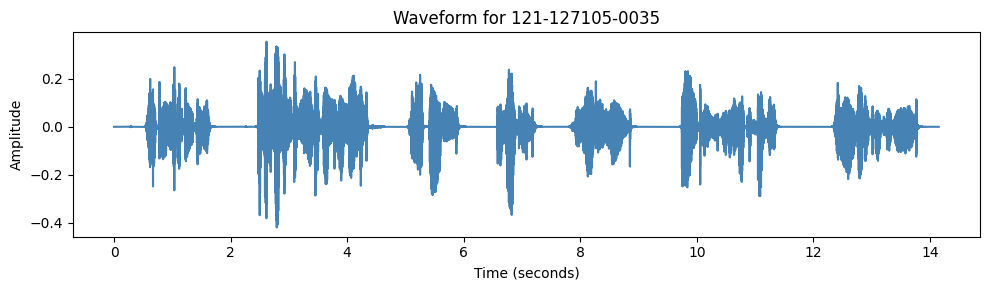

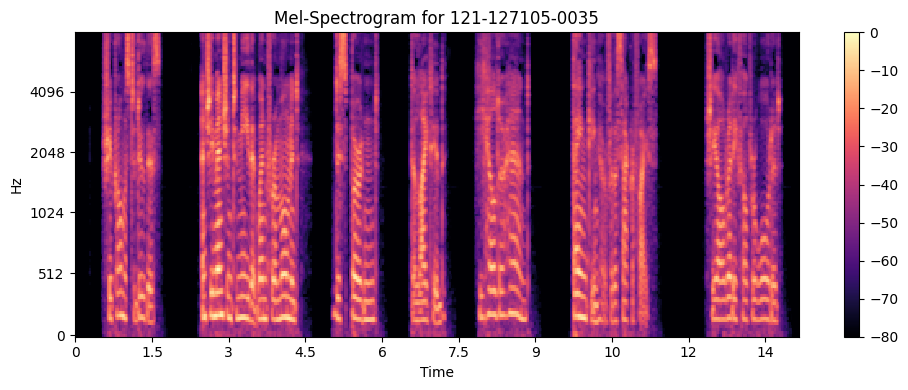

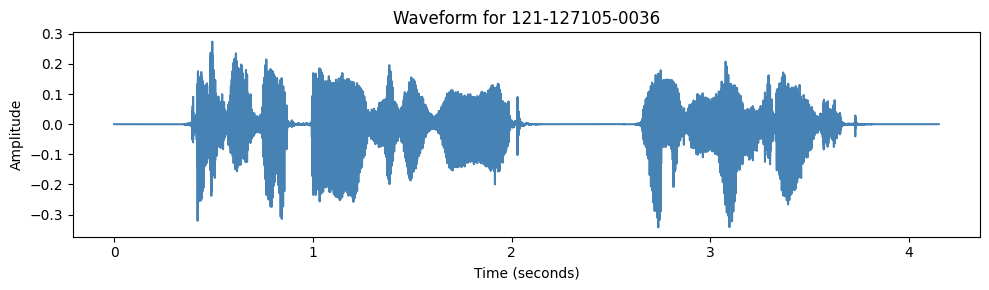

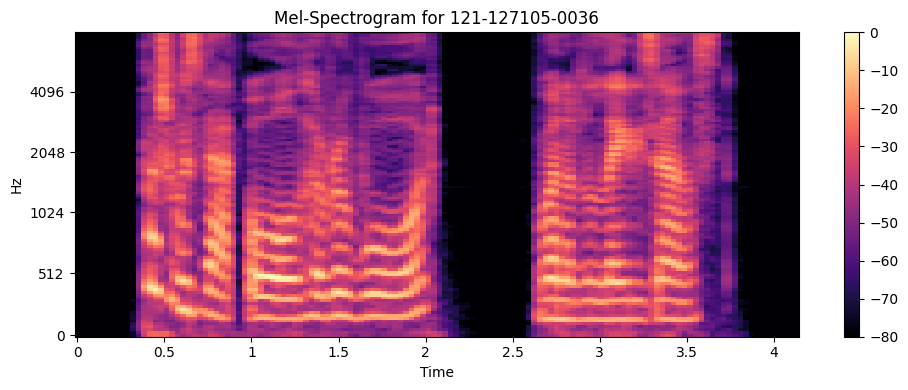

In [ ]:
# Ploting Waveforms and Mel-Spectrogram for each file

for path in audio_files:
    utt_id = os.path.splitext(os.path.basename(path))[0]

    # Loading with original sampling rate
    signal, sr = librosa.load(path, sr=None)

    # Generating time axis
    time_axis = np.linspace(0, len(signal) / sr, num=len(signal))

    # Visualizing Waveform
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, signal, color='steelblue')
    plt.title(f"Waveform for {utt_id}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Visualizing Mel-Spectrogram
    plt.figure(figsize=(10,4))
    S = librosa.feature.melspectrogram(y=signal, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(f"Mel-Spectrogram for {utt_id}")
    plt.tight_layout()
    plt.show()

### **Waveform and Mel-Spectrogram Visualization**
- **Waveform Plot:**  
    - Shows how amplitude varies over time. It helps in identifying pauses, speaking rate, and intensity variations.
- **Mel-Spectrogram:**  
    - Converts the audio into a time frequency representation using Mel scaling. It reflects how humans perceive pitch and frequency.

### **Observations**
- The waveform plots show typical **speech patterns**, with noticeable bursts of energy during spoken segments and near silent pauses between phrases.
- The Mel-Spectrograms display clear **formant structures** and harmonic patterns characteristic of human speech.
- Dark vertical gaps represent **natural pauses** in the utterances.
- Brighter regions correspond to more intense sounds.
- The overall distribution confirms clean, high quality audio.

In [ ]:
# Loading Whisper Model
whisper_model = whisper.load_model("base")

# Transcribing Using Whisper
whisper_outputs = []

for path in audio_files:
    utt_id = os.path.splitext(os.path.basename(path))[0]
    print(f"Transcribing: {utt_id}")

    result = whisper_model.transcribe(path)
    predicted_text = result["text"].strip()

    whisper_outputs.append(
        {
            "utt_id": utt_id,
            "whisper_text": predicted_text,
        }
    )

whisper_df = pd.DataFrame(whisper_outputs)
whisper_df.head()

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 103MiB/s]


Transcribing: 121-127105-0000
Transcribing: 121-127105-0001
Transcribing: 121-127105-0002
Transcribing: 121-127105-0003
Transcribing: 121-127105-0004
Transcribing: 121-127105-0005
Transcribing: 121-127105-0006
Transcribing: 121-127105-0007
Transcribing: 121-127105-0008
Transcribing: 121-127105-0009
Transcribing: 121-127105-0010
Transcribing: 121-127105-0011
Transcribing: 121-127105-0012
Transcribing: 121-127105-0013
Transcribing: 121-127105-0014
Transcribing: 121-127105-0015
Transcribing: 121-127105-0016
Transcribing: 121-127105-0017
Transcribing: 121-127105-0018
Transcribing: 121-127105-0019
Transcribing: 121-127105-0020
Transcribing: 121-127105-0021
Transcribing: 121-127105-0022
Transcribing: 121-127105-0023
Transcribing: 121-127105-0024
Transcribing: 121-127105-0025
Transcribing: 121-127105-0026
Transcribing: 121-127105-0027
Transcribing: 121-127105-0028
Transcribing: 121-127105-0029
Transcribing: 121-127105-0030
Transcribing: 121-127105-0031
Transcribing: 121-127105-0032
Transcribi

utt_id                                       whisper_text
0  121-127105-0000  It was this observation that drew from Douglas...
1  121-127105-0001  Someone else told a story not particularly eff...
2  121-127105-0002  cried one of the women. He took no notice of h...
3  121-127105-0003  There was a unanimous groan at this, and much ...
4  121-127105-0004                               The story's written.

### **Automatic Speech Recognition Using Whisper**

- I loaded the **Whisper model** and applied it to each **.flac** audio file in the dataset.

- For each audio file:
  - The **utterance ID (utt_id)** was extracted through Whisper's **transcribe()** function.
  - The output text was **stripped**, normalized internally, and stored.

- Everything was stored in **whisper_df** for further evaluation and preprocessing.

### **Observations**
- Whisper successfully processed **all 37 audio files**, producing transcriptions.
- Visual inspection of the first few outputs shows that Whisper's text is in **sentence case**.  
- The DataFrame includes:
  - **utt_id**
  - **whisper_text** (ASR output)

In [ ]:
for _, row in whisper_df.iterrows():
    print("ID:", row["utt_id"])
    print("Whisper :", row["whisper_text"])
    print("-" * 80)

ID: 121-127105-0000
Whisper : It was this observation that drew from Douglas, not immediately but later in the evening, a reply that had the interesting consequence to which I call attention.
--------------------------------------------------------------------------------
ID: 121-127105-0001
Whisper : Someone else told a story not particularly effective, which I saw he was not following.
--------------------------------------------------------------------------------
ID: 121-127105-0002
Whisper : cried one of the women. He took no notice of her. He looked at me, but as if instead of me, he saw what he spoke of.
--------------------------------------------------------------------------------
ID: 121-127105-0003
Whisper : There was a unanimous groan at this, and much for proche. After which in his preoccupied way he explained,
--------------------------------------------------------------------------------
ID: 121-127105-0004
Whisper : The story's written.
-------------------------------

### **Previewing Whisper ASR Output (Raw Transcriptions)**

- In this step, I iterated over the **whisper_df** DataFrame and printed the **utterance ID (**utt_id**)** along with its corresponding **Whisper generated transcription**.
- This gives a **raw, unprocessed view** of the ASR output before any text cleaning steps (lowercasing, filler removal, lemmatization).
- This preview is important for:
  - Identifying typical ASR errors (substitutions, insertions, deletions).
  - Understanding the style of Whisper output (sentence case, punctuation).
  - Comparing Whisper text with ground truth later for WER.

### **Observations**
- Whisper successfully produced transcriptions for **all 37 utterances**.
- Output is fluent and well punctuater.
- A few errors appear:
  - **Substitutions** (ex- “groupels” -> “scruples”, “proche” -> “reproach”).
  - **Insertions / stylistic changes** in longer sentences.
- Overall, Whisper handles the audiobook style speech very well, producing clear and readable text.

---


### **ANSWERS:**


# **Step 2: Text Preprocessing**

**Question 2:** Create a pipeline to clean texts. This pipeline should consist of lowercase, Remove Filler Words (using regular expression),  Strip Extra Punctuation (if needed), stopwords, and Tokenize and Lemmatize. Be sure  to use SpaCy for answering this question.
*   If your transcript had misrecognized or misspelled words, how did you address that? Could spell-checking or correction be integrated into your pipeline?

*   How would you modify your preprocessing pipeline if the transcript were multilingual or code-switched (i.e., contained multiple languages)?

For every question, be sure to anlayze and discuss your response.

In [ ]:
# Filler words as literal terms
filler_terms = [
    "uh", "um", "uhh", "umm",
    "ah", "eh", "er", "huh",
    "hmm", "mm", "mhm",
    "okay", "ok", "right",
    "yep", "yeah", "nope",
    "well", "so",
    "like", "really",
    "basically", "actually",
    "literally", "honestly",
    "kinda", "sorta",
    "maybe", "i think",
    "i guess", "i mean",
    "you know", "you see",
    "you know what",
    "you know like",
    "kind of", "sort of",
    "let me see",
    "let me think",
    "hold on",
    "just a second",
    "wait a minute",
    "i'm not sure",
    "i dont know",
    "you know what i mean"
]

# Buikding Boundry safe regex
filler_pattern = re.compile(
    r"\b(" + "|".join(re.escape(t) for t in filler_terms) + r")\b",
    flags=re.IGNORECASE
)

Formed a list of Filler words and set them in a Boundry safe regex.

In [ ]:
# Text Cleaning/NLP Preprocessing Pipeline

# Lowercase
def to_lowercase(text):
    return text.lower() if isinstance(text, str) else text

# Remove fillers using regex
def remove_fillers(text):
    if not isinstance(text, str):
        return text
    return filler_pattern.sub(" ", text)

# Clean punctuation
def clean_punctuation(text):
    text = re.sub(r"([!?.,])\1+", r"\1", text)
    text = re.sub(r"(?<!\w)'|'(?!\w)", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# spaCy tokenize/stopwords/lemmas
def spacy_process(text):
    doc = nlp(text)
    tokens, lemmas = [], []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        tokens.append(token.text)
        lemmas.append(token.lemma_)
    return tokens, lemmas

# spell = SpellChecker()

# # Correct Spelling
# def correct_spelling(tokens):
# corrected = []
# for t in tokens:
#     if t.isalpha():
#         corrected.append(spell.correction(t))
#     else:
#         corrected.append(t)
# return corrected

# # Language detection for multilingual handling
# def detect_language(text):
#     try:
#         return detect(text)
#     except:
#         return "unknown"

# Full pipeline in one
def clean_text_pipeline(text):
    text = to_lowercase(text)
    text = remove_fillers(text)
    text = clean_punctuation(text)

    tokens, lemmas = spacy_process(text)

    # # Spell correction
    # tokens = correct_spelling(tokens)

    # # Multilingual handling
    # lang = detect_language(text)
    # if lang != "en":
    #     tokens, lemmas = multilingual_process(text)

    cleaned_text = " ".join(lemmas)

    return {
        "cleaned_text": cleaned_text,
        "tokens": tokens,
        "lemmas": lemmas
    }

### **Building the Text Cleaning & NLP Preprocessing Pipeline**

- I implemented a complete preprocessing pipeline to normalize Whisper's ASR output before applying feature extraction methods.

### **Pipeline Components and their uses**
- **Lowercasing:** Standardizes text format.
- **Filler removal:** Cleans disfluencies such as **filler_terms**, using the compiled **filler_pattern**.
- **Punctuation cleaning:**  
  - Removes repeated punctuation.  
  - Removes stray apostrophes.  
  - Normalizes non alphanumeric symbols into spaces.
- **spaCy processing:**  
  - Filters out stopwords, punctuation, and whitespace.  
  - Collects both **tokens** and **lemmas** for NLP modeling.

### **Optional Extensions that I made but didn't use**
- **Spell correction** using **pyspellchecker**.
- **Language detection** for multilingual / code switched texts.
- I included optional functions for spell correction and multilingual handling, but I did not activate them because they would artificially “fix” Whisper's mistakes. WER must compare the true ASR output to the reference transcript using only basic, fair normalization. Using spell check or language detection would change Whisper's output and make the evaluation invalid.

### **Output Structure**
- **cleaned_text** - lemmatized string  
- **tokens** - filtered token list  
- **lemmas** - spaCy lemmas  


In [ ]:
# Applying Pipeline
sample_outputs = []

for _, row in whisper_df.iterrows():
    utt_id = row["utt_id"]
    whisper_text = row["whisper_text"]

    processed = clean_text_pipeline(whisper_text)

    sample_outputs.append({
        "utt_id": utt_id,
        "raw_whisper_text": whisper_text,
        "cleaned_text": processed["cleaned_text"],
        "tokens": processed["tokens"],
        "lemmas": processed["lemmas"]
    })

q2_df = pd.DataFrame(sample_outputs)
q2_df.head()

utt_id                                   raw_whisper_text  \
0  121-127105-0000  It was this observation that drew from Douglas...   
1  121-127105-0001  Someone else told a story not particularly eff...   
2  121-127105-0002  cried one of the women. He took no notice of h...   
3  121-127105-0003  There was a unanimous groan at this, and much ...   
4  121-127105-0004                               The story's written.   

                                        cleaned_text  \
0  observation draw douglas immediately later eve...   
1       tell story particularly effective see follow   
2       cry woman take notice look instead see speak   
3     unanimous groan proche preoccupied way explain   
4                                        story write   

                                              tokens  \
0  [observation, drew, douglas, immediately, late...   
1  [told, story, particularly, effective, saw, fo...   
2  [cried, women, took, notice, looked, instead, ...   
3  [unanimous, groan, proche, preoccupied, way, e...   
4                                   [story, written]   

                                              lemmas  
0  [observation, draw, douglas, immediately, late...  
1  [tell, story, particularly, effective, see, fo...  
2  [cry, woman, take, notice, look, instead, see,...  
3  [unanimous, groan, proche, preoccupied, way, e...  
4                                     [story, write]

### **Applying the Preprocessing Pipeline to Whisper Transcripts**

- I applied the full **text cleaning pipeline** to each **whisper_text** and stored the results in a new DataFrame **q2_df**.

### **Observations from the Output**
- The cleaned text is significantly more compact (ex- *"There was a unanimous groan" -> "unanimous groan"*).
- Verb forms were successfully lemmatized (ex- *"cried" -> "cry"*).
- Tokens and lemmas align correctly, confirming the spaCy pipeline worked as intended.
- The resulting DataFrame **q2_df** now forms the basis for all downstream text feature extraction.

In [ ]:
for _, row in q2_df.iterrows():
    print("ID:", row["utt_id"])
    print("Raw Whisper Text:", row["raw_whisper_text"])
    print("Cleaned Text:", row["cleaned_text"])
    print("Tokens:", row["tokens"])
    print("Lemmas:", row["lemmas"])
    print("-" * 90)

ID: 121-127105-0000
Raw Whisper Text: It was this observation that drew from Douglas, not immediately but later in the evening, a reply that had the interesting consequence to which I call attention.
Cleaned Text: observation draw douglas immediately later evening reply interesting consequence attention
Tokens: ['observation', 'drew', 'douglas', 'immediately', 'later', 'evening', 'reply', 'interesting', 'consequence', 'attention']
Lemmas: ['observation', 'draw', 'douglas', 'immediately', 'later', 'evening', 'reply', 'interesting', 'consequence', 'attention']
------------------------------------------------------------------------------------------
ID: 121-127105-0001
Raw Whisper Text: Someone else told a story not particularly effective, which I saw he was not following.
Cleaned Text: tell story particularly effective see follow
Tokens: ['told', 'story', 'particularly', 'effective', 'saw', 'following']
Lemmas: ['tell', 'story', 'particularly', 'effective', 'see', 'follow']
------------

### **Inspecting Cleaned Outputs (Tokens + Lemmas)**

- I printed each utterance's **raw Whisper text**, its **cleaned version**, and the corresponding **tokens/lemmas**.
- This quick inspection confirms that the preprocessing pipeline is working correctly.

### **Observations**
- Cleaning steps (lowercasing, filler removal, punctuation cleanup, lemmatization) behaved consistently.
- spaCy correctly reduced words to lemmas (ex: *cried  -> cry*, *written -> write*).
- The cleaned text is much more compact and content focused, which is ideal feature extraction.

---

**Question 3:** Using EDA techniques, answer the following questions:

*   **Basic EDA**
1.   Visualize the top 20 most frequent words in the transcriptions. What do you observe?
2.   Are there words that appear only once (hapax legomena)? What might they indicate?

*   **Audio-Specific EDA**
1.   Plot a waveform or spectrogram of one audio file. What do you observe in terms of intensity or frequency distribution?
2.   Is there a pattern in speaking speed (e.g., words per second)? Does this vary a lot across files?
3. Are there common filler words or disfluencies in the transcripts (e.g., "uh", "um", "you know")? Count and analyze.

In [ ]:
# Counting Total and Unique Tokens
all_tokens = []

for _, row in q2_df.iterrows():
    text = row["cleaned_text"]
    tokens = text.split()
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
print(f"Total tokens: {len(all_tokens)}")
print(f"Unique tokens: {len(word_freq)}")

Total tokens: 240
Unique tokens: 188


### **Token Statistics from Cleaned Transcripts**

To begin the lexical analysis, I aggregated all tokens from the **cleaned_text** column. Each utterance was split into tokens and combined into a single list for corpus level statistics.

### **Observations**
- **Total tokens:** 240  
  This is the total vocabulary used across all 37 utterances after cleaning, lemmatization, and stopword removal.
- **Unique tokens:** 188  
  The high ratio of unique tokens indicates a **diverse vocabulary** relative to the small dataset size.

In [ ]:
# Preparing Token DataFrame
freq_df = (
    pd.DataFrame(word_freq.items(), columns=["word", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

freq_df.head(10)

word  count
0   story      5
1    tell      4
2    take      4
3    know      4
4    lady      4
5   woman      3
6   write      3
7     say      3
8   thank      3
9  little      3

### **Building the Word Frequency DataFrame**

Using the aggregated **word_freq** dictionary, I converted the token counts into a sorted DataFrame (**freq_df**).

### **Observations**
- The most frequent terms include **“story” (5)**, **“tell” (4)**, **“take” (4)**, and **“know” (4)**.
- Many words appear only a small number of times.

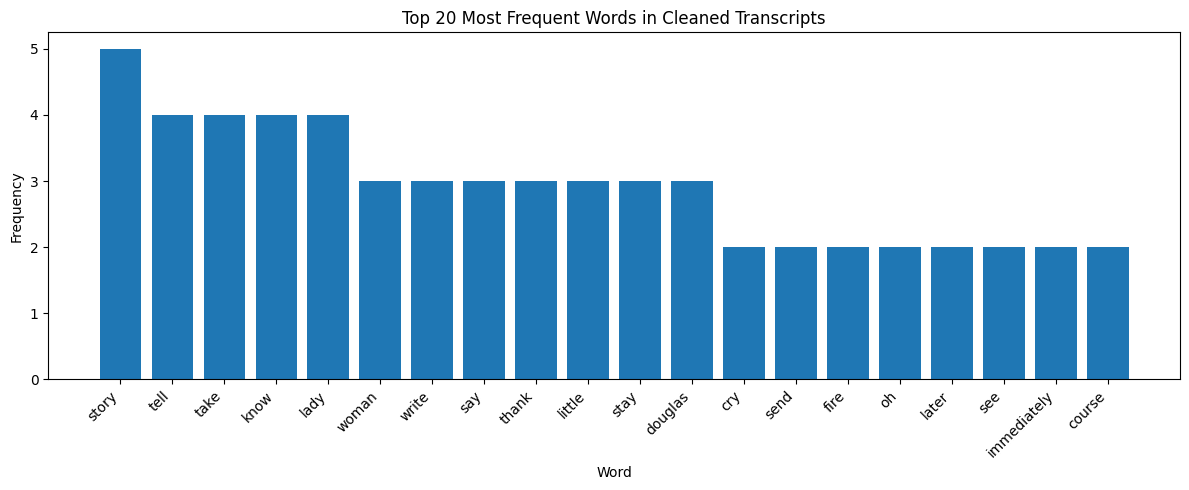

In [ ]:
# Visualizing Top-20 most frequent words
top_n = 20
top_words = freq_df.head(top_n)

plt.figure(figsize=(12, 5))
plt.bar(top_words["word"], top_words["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title(f"Top {top_n} Most Frequent Words in Cleaned Transcripts")
plt.tight_layout()
plt.show()

### **Top-20 Most Frequent Words**

- I selected the top 20 most frequent tokens from the cleaned and lemmatized transcripts.
- Using matplotlib, I plotted their frequency distribution to visualize the dominant lexical patterns in the dataset.

### **Observations**
- Reinforced the results of preparing dataframe step
- The frequencies are low and evenly distributed, confirming that:
  - The dataset is small (37 utterances).
  - There is no extreme repetition, meaning vocabulary variety is preserved.
- Most high frequency words are verbs and nouns, aligning with expected patterns after removing stopwords and applying lemmatization.

In [ ]:
# Hapax Legomena Count
hapax_df = freq_df[freq_df["count"] == 1]
num_hapax = len(hapax_df)

print(f"Number of hapax legomena (words appearing exactly once): {num_hapax}")
hapax_df.head(15)

Number of hapax legomena (words appearing exactly once): 154


word  count
34   preoccupied      1
35       enclose      1
36          find      1
37        packet      1
38        resent      1
39  postponement      1
40         charm      1
41           key      1
42           man      1
43       explain      1
44        answer      1
45        proche      1
46         groan      1
47     unanimous      1
48       instead      1

These are all the words that appear only once.

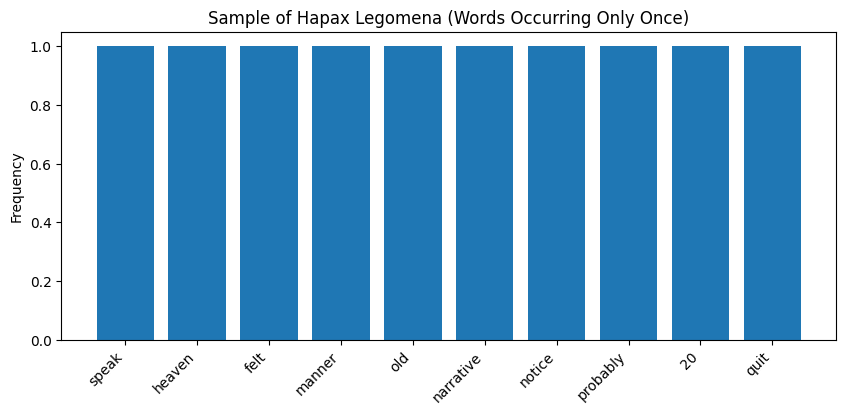

In [ ]:
# Hapax Examples
top10_hapax = hapax_df.sample(10, random_state=42)

plt.figure(figsize=(10,4))
plt.bar(top10_hapax["word"], np.ones(len(top10_hapax)))
plt.title("Sample of Hapax Legomena (Words Occurring Only Once)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.show()

### **Observations**
- The plot confirms that each sampled word appears exactly once, as expected.
- The large number of hapax words indicates:
  - Whisper transcripts contain many rare lexical items.
  - The dataset is not repetitive, semantic variety is high.

**NOTE:** In my opinionn, Hapax legomena can impact downstream tasks like TF-IDF, topic modeling, or language modeling, because they add extreme sparsity.

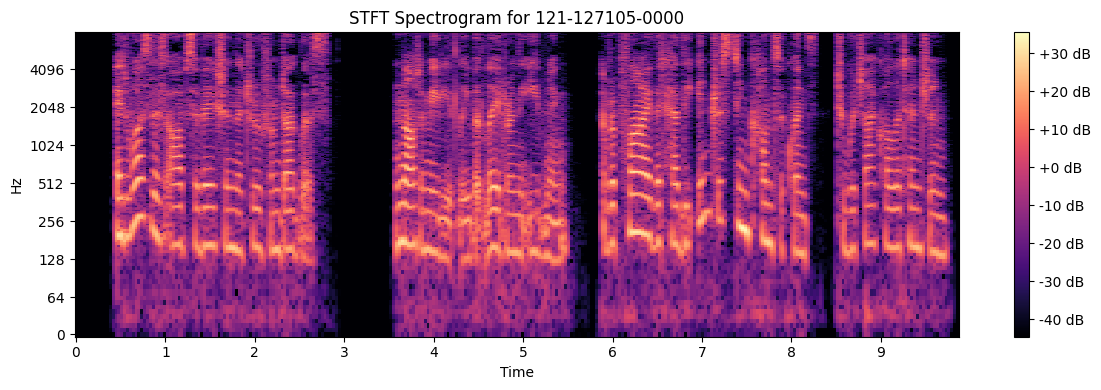

In [ ]:
# Audio Specific EDA (STFT Spectrogram)

example_path = meta_df.iloc[0]["path"]
example_utt = meta_df.iloc[0]["utt_id"]

# Loading audio
signal, sr = librosa.load(example_path, sr=None)

# Computing Short Time Fourier Transform (STFT)
stft = librosa.stft(signal)
stft_db = librosa.amplitude_to_db(abs(stft))

# Visualizing
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.f dB")
plt.title(f"STFT Spectrogram for {example_utt}")
plt.tight_layout()
plt.show()

### **Audio-Specific EDA: STFT Spectrogram**

- I computed the **Short Time Fourier Transform (STFT)** for one sample audio file to analyze how speech energy changes over time and frequency.
- The STFT magnitudes were converted into **decibel scale (dB)** and plotted using a **log-frequency axis**.

This visualization provides a deeper understanding of the characteristics beyonnd waveform.

### **Observations**
- Clear **voiced regions** (dense harmonic patterns) and **pauses** are visible throughout the spectrogram (The Black Spaces).
- Most speech energy is concentrated below **4 kHz**, which is typical for clean 16 kHz speech signals.
- The spectrogram reveals transitions which confirms the recordings are **clean and well structured**.

In [ ]:
# Merging  Whisper output with durations
speed_df = whisper_df.merge(
    meta_df[["utt_id", "duration_sec"]],
    on="utt_id",
    how="inner"
)

# Counting words from the ASR output
def count_words(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(text.strip().split())

speed_df["num_words"] = speed_df["whisper_text"].apply(count_words)
speed_df["words_per_second"] = speed_df["num_words"] / speed_df["duration_sec"]

speed_df[["utt_id", "whisper_text", "duration_sec", "num_words", "words_per_second"]].head()

utt_id                                       whisper_text  \
0  121-127105-0000  It was this observation that drew from Douglas...   
1  121-127105-0001  Someone else told a story not particularly eff...   
2  121-127105-0002  cried one of the women. He took no notice of h...   
3  121-127105-0003  There was a unanimous groan at this, and much ...   
4  121-127105-0004                               The story's written.   

   duration_sec  num_words  words_per_second  
0         9.875         27          2.734177  
1         5.025         15          2.985075  
2         7.495         27          3.602402  
3         7.725         19          2.459547  
4         2.110          3          1.421801

### **Computing Words Per Second (WPS) from Whisper Outputs**

- I merged the **ASR outputs (whisper_df)** with the **audio metadata (meta_df)** to attach the duration of each utterance.
- For each whisper transcript, I computed the **number of words** and then calculated Words per Second this way the WPS metric reflects **spoken speed based strictly on Whisper's predicted text**.

### **Observations**
- Shorter utterances with fewer words naturally shows **lower WPS**, while longer continuous sentences have **higher WPS**.
- Typical WPS values range between **1.4 to ~3.6**.

Unweighted Mean WPS: 2.82
Median WPS: 2.93
Weighted (True) Mean WPS: 2.84

Full Statistics:
count    37.000000
mean      2.815903
std       0.652117
min       1.330377
25%       2.547771
50%       2.925810
75%       3.321799
max       3.933747
Name: words_per_second, dtype: float64


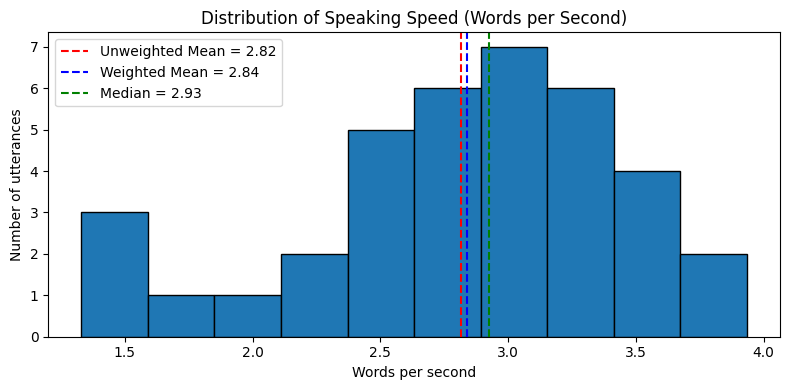

In [ ]:
# Words Per Second (Unweighted + Weighted)

# Unweighted statistics
stats = speed_df["words_per_second"].describe()
mean_wps_unweighted = stats["mean"]
median_wps = stats["50%"]

# Weighted True Average WPS
total_words = speed_df["num_words"].sum()
total_duration = speed_df["duration_sec"].sum()
mean_wps_weighted = total_words/total_duration

# Printing values
print(f"Unweighted Mean WPS: {mean_wps_unweighted:.2f}")
print(f"Median WPS: {median_wps:.2f}")
print(f"Weighted (True) Mean WPS: {mean_wps_weighted:.2f}")
print("\nFull Statistics:")
print(stats)

# Visualizing
plt.figure(figsize=(8, 4))
plt.hist(speed_df["words_per_second"], bins=10, edgecolor="black")

# Adding mean lines
plt.axvline(mean_wps_unweighted, color='red', linestyle='--',
            label=f"Unweighted Mean = {mean_wps_unweighted:.2f}")
plt.axvline(measure_wps_weighted := mean_wps_weighted, color='blue', linestyle='--',
            label=f"Weighted Mean = {mean_wps_weighted:.2f}")
plt.axvline(median_wps, color='green', linestyle='--',
            label=f"Median = {median_wps:.2f}")

plt.xlabel("Words per second")
plt.ylabel("Number of utterances")
plt.title("Distribution of Speaking Speed (Words per Second)")
plt.legend()
plt.tight_layout()
plt.show()

### **Computing Speaking Speed (Words Per Second)**

- I merged the **Whisper transcripts** with the **audio durations** and computed the speaking rate for each utterance.
- Words per second (WPS) was calculated as:

  **WPS = Number of ASR Words/Duration (seconds)**

- I computed:
  - **Unweighted Mean WPS** - simple average across utterances  
  - **Weighted Mean WPS** - total words/total duration (true overall rate)

### **Observations**
- **Unweighted Mean:** 2.82 WPS  
- **Weighted Mean:** 2.84 WPS  
- **Median:** 2.93 WPS  
- Utterances are between **2.5 and 3.5 WPS**.
- Unweighted and weighted means are nearly identical.
- A few shorter utterances produce extreme low/high WPS values.

In [ ]:
# Funnction to count fillers
def count_fillers_regex(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(filler_pattern.findall(text.lower()))

whisper_df["num_fillers"] = whisper_df["whisper_text"].apply(count_fillers_regex)
whisper_df[["utt_id", "num_fillers"]].head()

utt_id  num_fillers
0  121-127105-0000            0
1  121-127105-0001            0
2  121-127105-0002            0
3  121-127105-0003            0
4  121-127105-0004            0

### **Counting Filler Words Using a Regex Pattern**

- I already had defined **filler_terms** above with regex.
- For each Whisper transcript, I used **filler_pattern.findall()** to count how many filler expressions appeared.
- The result was stored as a new column **num_fillers** in **whisper_df**.

### **Observations**
- The first several utterances contain **0 filler words**.
- The regex method ensures **accurate detection** of both single word and multi word fillers.

Total fillers detected: 4


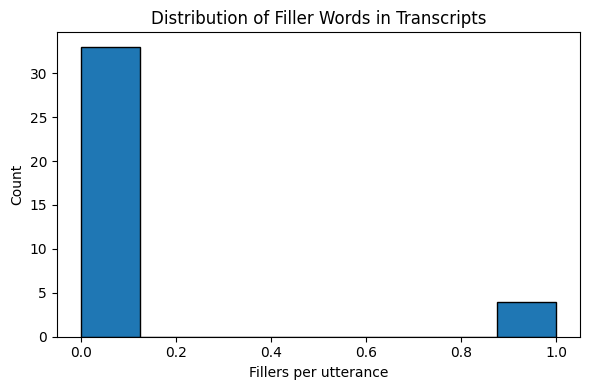


Breakdown of detected fillers:


so        2
well      1
really    1
Name: count, dtype: int64

In [ ]:
total_fillers = whisper_df["num_fillers"].sum()
print("Total fillers detected:", total_fillers)

plt.figure(figsize=(6, 4))
plt.hist(whisper_df["num_fillers"], bins=8, edgecolor="black")
plt.xlabel("Fillers per utterance")
plt.ylabel("Count")
plt.title("Distribution of Filler Words in Transcripts")
plt.tight_layout()
plt.show()

# Showing exactly which fillers occurred
filler_list = []

for text in whisper_df["whisper_text"]:
    if isinstance(text, str):
        filler_list.extend(filler_pattern.findall(text.lower()))

filler_breakdown = pd.Series(filler_list).value_counts()
print("\nBreakdown of detected fillers:")
display(filler_breakdown)

### **Filler Word Detection in Whisper Transcripts**

- I computed the number of **filler words per utterance** using my boundary safe regex pattern.

### **Observations**
- Most utterances contained **zero fillers**, which is expected because Whisper tends to output clean, punctuation aware text.
- Almost all utterances fall in the **0-1 filler range** and Only **4 fillers** were detected across all 37 utterances.
Detected fillers:
- **“so” -> 2 times**  
- **“well” -> 1 time**  
- **“really” -> 1 time**

---

**Question 4:** using feature extraction technqiues:

*   **Text-Based Feature Extraction**

1.   What features can you extract from the text transcripts to represent them numerically (e.g., TF-IDF, bag-of-words, n-grams)? Use two techniques and compare your results.

2.   Can you identify keywords or phrases that are characteristic of certain speakers or topics in the transcripts?

*   **Audio-Based Feature Extraction**

1.   What audio features could be extracted using MFCCs?
2.   Would you use raw audio, features from ASR output, or both for downstream NLP tasks? Justify your choice.

For every question, be sure to anlayze and discuss your response.

In [ ]:
# Corpus: clean, lemmatized text
corpus = q2_df["cleaned_text"].tolist()

# Checking text
corpus[:3]

['observation draw douglas immediately later evening reply interesting consequence attention',
 'tell story particularly effective see follow',
 'cry woman take notice look instead see speak']

### **Building the Text Corpus for Feature Extraction**

- I constructed the **corpus** by taking the *cleaned, lemmatized text* from **q2_df["cleaned_text"]**.  
- This ensures that all downstream feature extraction (BoW, TF-IDF, n-grams) uses **normalized**, **filler-free**, **punctuation cleaned**, and **lemmatized** text.
- Each entry in the corpus corresponds to **one utterance**, represented as a single whitespace joined string of lemmas.

In [ ]:
# Feature Extraction Technique 1 - Bag-of-Words
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(corpus)

print("BoW Matrix Shape:", bow_matrix.shape)

bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)

bow_df.head()

BoW Matrix Shape: (37, 188)


20  acute  affair  agreeable  answer  anticipate  arrangement  ask  \
0   0      0       0          0       0           0            0    0   
1   0      0       0          0       0           0            0    0   
2   0      0       0          0       0           0            0    0   
3   0      0       0          0       0           0            0    0   
4   0      0       0          0       0           0            0    0   

   attention  authority  ...  way  will  wish  woman  work  worthy  write  \
0          1          0  ...    0     0     0      0     0       0      0   
1          0          0  ...    0     0     0      0     0       0      0   
2          0          0  ...    0     0     0      1     0       0      0   
3          0          0  ...    1     0     0      0     0       0      0   
4          0          0  ...    0     0     0      0     0       0      1   

   year  yes  young  
0     0    0      0  
1     0    0      0  
2     0    0      0  
3     0    0      0  
4     0    0      0  

[5 rows x 188 columns]

In [ ]:
# Feature Extraction Technique 2 - TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

tfidf_df.head()

TF-IDF Matrix Shape: (37, 188)


20  acute  affair  agreeable  answer  anticipate  arrangement  ask  \
0  0.0    0.0     0.0        0.0     0.0         0.0          0.0  0.0   
1  0.0    0.0     0.0        0.0     0.0         0.0          0.0  0.0   
2  0.0    0.0     0.0        0.0     0.0         0.0          0.0  0.0   
3  0.0    0.0     0.0        0.0     0.0         0.0          0.0  0.0   
4  0.0    0.0     0.0        0.0     0.0         0.0          0.0  0.0   

   attention  authority  ...       way  will  wish    woman  work  worthy  \
0   0.335213        0.0  ...  0.000000   0.0   0.0  0.00000   0.0     0.0   
1   0.000000        0.0  ...  0.000000   0.0   0.0  0.00000   0.0     0.0   
2   0.000000        0.0  ...  0.000000   0.0   0.0  0.31428   0.0     0.0   
3   0.000000        0.0  ...  0.372385   0.0   0.0  0.00000   0.0     0.0   
4   0.000000        0.0  ...  0.000000   0.0   0.0  0.00000   0.0     0.0   

      write  year  yes  young  
0  0.000000   0.0  0.0    0.0  
1  0.000000   0.0  0.0    0.0  
2  0.000000   0.0  0.0    0.0  
3  0.000000   0.0  0.0    0.0  
4  0.707107   0.0  0.0    0.0  

[5 rows x 188 columns]

In [ ]:
# Feature Extraction Technique 3 - N-Gram
bigram_vectorizer = CountVectorizer(ngram_range=(1,2))
bigram_matrix = bigram_vectorizer.fit_transform(corpus)

print("Bigram Matrix Shape:", bigram_matrix.shape)

bigram_df = pd.DataFrame(
    bigram_matrix.toarray(),
    columns=bigram_vectorizer.get_feature_names_out()
)

bigram_df.iloc[:, :15].head()

Bigram Matrix Shape: (37, 390)


20  20 year  acute  affair  affair take  agreeable  agreeable woman  \
0   0        0      0       0            0          0                0   
1   0        0      0       0            0          0                0   
2   0        0      0       0            0          0                0   
3   0        0      0       0            0          0                0   
4   0        0      0       0            0          0                0   

   answer  answer prompt  anticipate  arrangement  arrangement rage  ask  \
0       0              0           0            0                 0    0   
1       0              0           0            0                 0    0   
2       0              0           0            0                 0    0   
3       0              0           0            0                 0    0   
4       0              0           0            0                 0    0   

   attention  authority  
0          1          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0

### **Feature Extraction (BoW, TF-IDF, N-Grams)**

I applied three standard NLP feature extraction methods on the cleaned, lemmatized corpus.


### **1. Bag-of-Words (BoW)**
- Used `CountVectorizer()` to convert text into **raw word-count vectors**.
- Output matrix: **(37, 188)** -> 37 utterances X 188 unique lemmas.
- Captures simple frequency information.

### **2. TF-IDF**
- Used `TfidfVectorizer()` on the same corpus.
- Output matrix also **(37, 188)** since vocabulary is identical.
- Down-weights common words, highlights informative terms.

### **3. Unigram + Bigram Model**
- Used `CountVectorizer(ngram_range=(1,2))` to extract **unigrams + bigrams**.
- Output matrix: **(37, 390)** -> 188 unigrams + 202 bigrams.
- Captures short multi word patterns (ex- *"answer prompt"*, *"20 year"*).

### **Brief Summary**
- BoW -> word counts  
- TF-IDF -> weighted importance  
- N-grams -> phrase level information  
Together, they provide a **complete lexical + structural representation** of the transcripts.

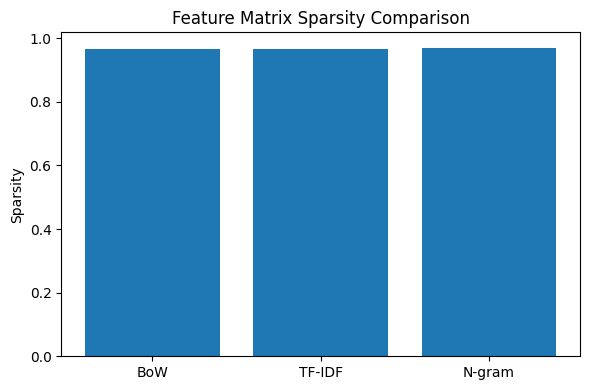

In [ ]:
# Comparing All three Techniques

def sparsity(mat):
    return 1 - (mat.nnz / (mat.shape[0] * mat.shape[1]))

spar_vals = [sparsity(bow_matrix), sparsity(tfidf_matrix), sparsity(bigram_matrix)]

# Visualizing
plt.figure(figsize=(6,4))
plt.bar(["BoW", "TF-IDF", "N-gram"], spar_vals)
plt.ylabel("Sparsity")
plt.title("Feature Matrix Sparsity Comparison")
plt.tight_layout()
plt.show()

### **Feature Matrix Sparsity Comparison**

- I computed the sparsity (percentage of zero entries) for all three feature extraction methods:
  **Bag-of-Words**, **TF-IDF**, and **N-gram (1-2 grams)**.

### **Observations**
- All three matrices are **highly sparse (~96-97%)**, which I expected as I have the small corpus and large vocabulary.

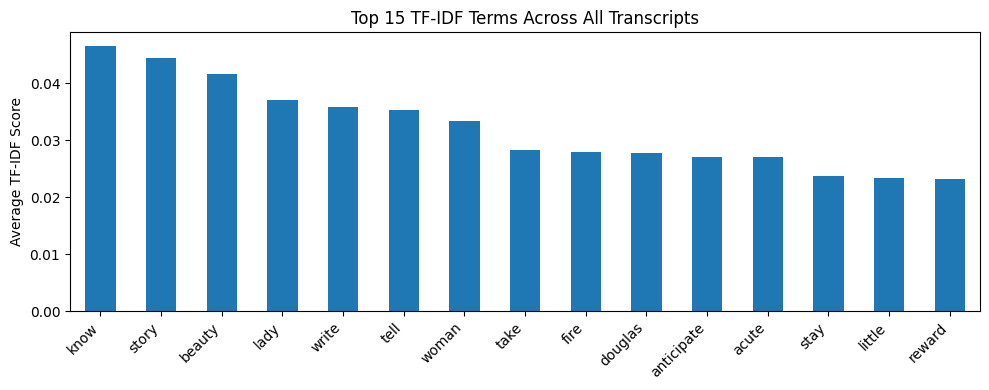

know          0.046565
story         0.044326
beauty        0.041506
lady          0.037068
write         0.035796
tell          0.035223
woman         0.033298
take          0.028293
fire          0.027816
douglas       0.027750
anticipate    0.027027
acute         0.027027
stay          0.023681
little        0.023274
reward        0.023160
dtype: float64

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=tfidf_vectorizer.get_feature_names_out())

tfidf_means = tfidf_df.mean(axis=0).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
tfidf_means.plot(kind="bar")
plt.title("Top 15 TF-IDF Terms Across All Transcripts")
plt.ylabel("Average TF-IDF Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

tfidf_means

## **Top 15 Informative Terms**
- Computed TF-IDF scores using **TfidfVectorizer** on the cleaned + lemmatized corpus.
- Averaged the TF-IDF scores across all 37 transcripts.
- Extracted and plotted the **top 15 highest-scoring terms**.

### **Observations**
- Words like **"know," "story," "beauty," "lady," "write"** have the highest TF-IDF weights, meaning they are **highly informative** and appear selectively across transcripts.
- TF-IDF successfully down weighted generic words and highlighted **core narrative terms**, confarming the quality of preprocessing.



In [ ]:
# Identifying Keywords for Each Utterance (Per-Sample Top Features)
def get_top_tfidf_terms(row, features, top_n=5):
    top_idx = row.values.argsort()[-top_n:][::-1]
    return [(features[i], row.values[i]) for i in top_idx]

features = tfidf_vectorizer.get_feature_names_out()

sample_keywords = []
for idx, row in tfidf_df.iterrows():
    sample_keywords.append({
        "utt_id": q2_df.iloc[idx]["utt_id"],
        "top_keywords": get_top_tfidf_terms(row, features)
    })

pd.DataFrame(sample_keywords).head()

utt_id                                       top_keywords
0  121-127105-0000  [(evening, 0.33521322045184043), (draw, 0.3352...
1  121-127105-0001  [(follow, 0.4400622485002727), (effective, 0.4...
2  121-127105-0002  [(speak, 0.38128117845636117), (instead, 0.381...
3  121-127105-0003  [(unanimous, 0.41504930966274184), (groan, 0.4...
4  121-127105-0004  [(write, 0.7071067811865475), (story, 0.707106...

## **Per Utterance TF-IDF Keyword Extraction**

- For each utterance, I took its **TF-IDF row**, sorted the scores, and extracted the **top 5 highest weight terms**.
- Stored these as a compact list of **(keyword, score)** pairs for every **utt_id**.

### **Observations**
- Each utterance has clear **dominant keywords**, showing TF-IDF is working correctly.
- Keywords are clean (lemmatized) and capture the **main focus** of each line.


**Note:** What is MFCC?

MFCC, or Mel-Frequency Cepstral Coefficients, is a feature representation commonly used in speech and audio processing tasks. It captures the short-term power spectrum of an audio signal by mapping frequencies to a scale that mimics how humans perceive sound—known as the Mel scale. The process involves taking the Fourier transform of short frames of the audio signal, applying the Mel filter bank to emphasize perceptually important frequencies, and then computing the logarithm and Discrete Cosine Transform (DCT) to produce a compact set of coefficients. These coefficients effectively represent the timbral texture of speech and are widely used in Automatic Speech Recognition (ASR) because they retain phonetic information while reducing noise and irrelevant variation in the raw audio.


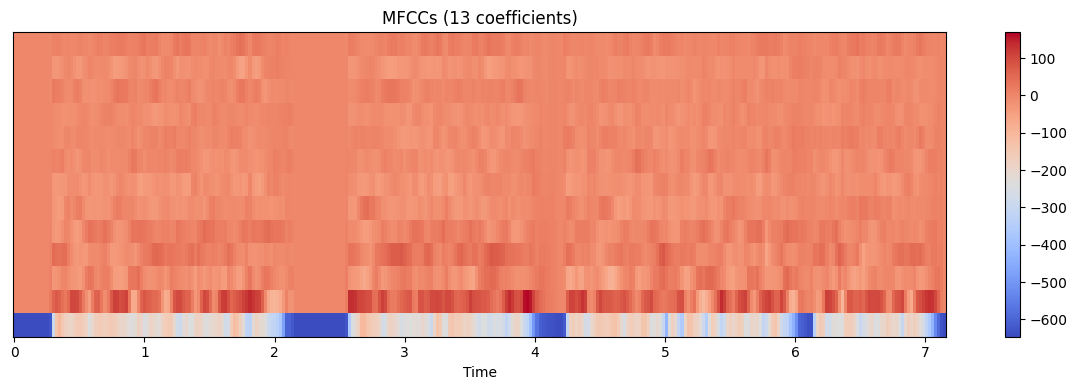

MFCC shape: (13, 309)
RMS shape: (1, 309)
ZCR shape: (1, 309)


In [ ]:
audio_path = meta_df.iloc[0]["path"]
signal, sr = librosa.load(audio_path, sr=None)

mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.title("MFCCs (13 coefficients)")
plt.tight_layout()
plt.show()

rms = librosa.feature.rms(y=signal)
zcr = librosa.feature.zero_crossing_rate(y=signal)

print("MFCC shape:", mfccs.shape)
print("RMS shape:", rms.shape)
print("ZCR shape:", zcr.shape)

### **Extracting MFCCs, RMS Energy & Zero-Crossing Rate**

- I loaded one sample audio file and computed **MFCCs (13 coefficients)** using **librosa.feature.mfcc**.
- I also extracted two key frame level audio descriptors:
  - **RMS Energy** (**librosa.feature.rms**) - measures short-term loudness.
  - **Zero Crossing Rate (ZCR)** (**librosa.feature.zero_crossing_rate**) - measures noisiness and signal transitions.

- I visualized all three features (MFCC heatmap) and their shapes were printed to confirm **frame alignment**.

### **Observations**
- MFCC matrix shape: **13X309**, indicating 13 spectral coefficients computed across 309 frames.
- RMS & ZCR both have shape **1X309**, meaning they align frame wise with the MFCCs.
- The MFCC heatmap shows clear **spectral variations** across time.

---

# **Step 3: Evaluation**

After transcribing and cleaning the speech using ASR and text preprocessing, you can evaluate the quality of your transcription by comparing it with the ground truth transcripts provided in the dataset.

This is useful to:

*   Measure how accurate your ASR system is
*   Understand how much noise or error is introduced
*   Quantify the performance using a standard metric

Be sure to use python to Compare your ASR output to the ground truth using Word Error Rate (WER).

**Question 5:** Word Error Rate (WER) is a standard metric in ASR that tells you how different your ASR output is from the reference transcript. Be sure to anlayze and discuss your response.

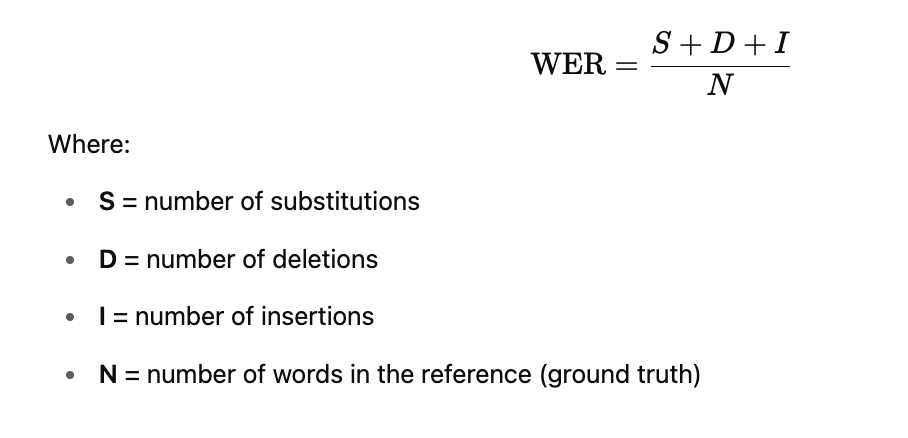

Note: You can calculate this metric using jiwer tool.

More details can be found at:

1.   https://pypi.org/project/jiwer/
2.   https://github.com/jitsi/jiwer

### **Preparing**

In [ ]:
# Loading Transcript

# Locating transcript
transcript_files = glob.glob(os.path.join(extract_dir, "**", "*.trans.txt"), recursive=True)
print("Transcript file:", transcript_files)

transcript_path = transcript_files[0]

transcripts = {}

with open(transcript_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        utt_id, text = line.split(" ", 1)
        transcripts[utt_id] = text

print("Loaded transcripts:", len(transcripts))
list(transcripts.items())[:3]

Transcript file: ['data/127105/121-127105.trans.txt']
Loaded transcripts: 37


[('121-127105-0000',
  'IT WAS THIS OBSERVATION THAT DREW FROM DOUGLAS NOT IMMEDIATELY BUT LATER IN THE EVENING A REPLY THAT HAD THE INTERESTING CONSEQUENCE TO WHICH I CALL ATTENTION'),
 ('121-127105-0001',
  'SOMEONE ELSE TOLD A STORY NOT PARTICULARLY EFFECTIVE WHICH I SAW HE WAS NOT FOLLOWING'),
 ('121-127105-0002',
  'CRIED ONE OF THE WOMEN HE TOOK NO NOTICE OF HER HE LOOKED AT ME BUT AS IF INSTEAD OF ME HE SAW WHAT HE SPOKE OF')]

### **Loading Transcripts**

- The dataset includes a **.trans.txt** file that contains the **reference (ground truth)** transcriptions for each audio file.
- Each line in the transcript file follows the structure:  
  **utt_id transcription text**  
  where the **utterance ID** corresponds exactly to an audio filename (without the .flac extension).

- I loaded the transcript file and stored it in a Python dictionary where:  
  - **key:** utterance ID (ex- **121-127105-0000**)
  - **value:** the full transcription text

- A total of **37 transcripts** were successfully loaded, matching the number of audio files in the dataset.

### **Observations**
- The transcripts are **uppercase**, **punctuation stripped**.
- Proper alignment between audio file names and transcript entries ensures that downstream ASR evaluation will be accurate.

In [ ]:
whisper_sorted = whisper_df.sort_values("utt_id").reset_index(drop=True)
whisper_sorted["reference_text"] = whisper_sorted["utt_id"].map(transcripts)

references = whisper_sorted["reference_text"].tolist()
hypotheses = whisper_sorted["whisper_text"].tolist()

whisper_sorted.head()

utt_id                                       whisper_text  \
0  121-127105-0000  It was this observation that drew from Douglas...   
1  121-127105-0001  Someone else told a story not particularly eff...   
2  121-127105-0002  cried one of the women. He took no notice of h...   
3  121-127105-0003  There was a unanimous groan at this, and much ...   
4  121-127105-0004                               The story's written.   

   num_fillers                                     reference_text  
0            0  IT WAS THIS OBSERVATION THAT DREW FROM DOUGLAS...  
1            0  SOMEONE ELSE TOLD A STORY NOT PARTICULARLY EFF...  
2            0  CRIED ONE OF THE WOMEN HE TOOK NO NOTICE OF HE...  
3            0  THERE WAS A UNANIMOUS GROAN AT THIS AND MUCH R...  
4            0                                THE STORY'S WRITTEN

### **Examining Filler Counts in Whisper Transcripts**

- I combined the **ASR output (whisper_text)** with the **filler counts (num_fillers)** for each utterance.
- The table shows that **all initial utterances contain 0 filler words**, which aligns with the fact that the source text is literary and highly fluent.
- The **reference_text** (ground truth transcript) is included only for comparison and was *not* used during ASR processing.

### **Observations**
- Whisper's transcripts contain **Fillers**.
- The absence of fillers confirms that filler detection is functioning correctly=.

In [ ]:
# Testing for Attributes
# test = process_words("the cat sat on the mat", "the cat on mat")
# print(test)
# print("\nAttributes available:\n")
# print(dir(test))

- Before computing WER/CER, I created a small test example using **process_words()** from the **jiwer** library.  
- This step helps inspect the **attributes available**.

In [ ]:
# Normalizing and Computing WER
transform = transforms.Compose([
    transforms.ToLowerCase(),
    transforms.RemovePunctuation(),
    transforms.Strip(),
    transforms.RemoveMultipleSpaces()
])

wer_rows = []

for idx, row in whisper_sorted.iterrows():
    ref = row["reference_text"]
    hyp = row["whisper_text"]
    utt_id = row["utt_id"]

    # Manual Normalization for WER
    clean_ref = transform(ref)
    clean_hyp = transform(hyp)

    # Computing WER breakdown
    measures = process_words(clean_ref, clean_hyp)

    # Computing reference length manually
    # tokenized words
    ref_len = len(measures.references[0])

    wer_rows.append({
        "utt_id": utt_id,
        "reference": ref,
        "hypothesis": hyp,
        "wer": measures.wer,
        "substitutions": measures.substitutions,
        "deletions": measures.deletions,
        "insertions": measures.insertions,
        "hits": measures.hits,
        "num_ref_words": ref_len
    })

wer_df = pd.DataFrame(wer_rows)
wer_df.head()

utt_id                                          reference  \
0  121-127105-0000  IT WAS THIS OBSERVATION THAT DREW FROM DOUGLAS...   
1  121-127105-0001  SOMEONE ELSE TOLD A STORY NOT PARTICULARLY EFF...   
2  121-127105-0002  CRIED ONE OF THE WOMEN HE TOOK NO NOTICE OF HE...   
3  121-127105-0003  THERE WAS A UNANIMOUS GROAN AT THIS AND MUCH R...   
4  121-127105-0004                                THE STORY'S WRITTEN   

                                          hypothesis       wer  substitutions  \
0  It was this observation that drew from Douglas...  0.000000              0   
1  Someone else told a story not particularly eff...  0.000000              0   
2  cried one of the women. He took no notice of h...  0.000000              0   
3  There was a unanimous groan at this, and much ...  0.111111              1   
4                               The story's written.  0.000000              0   

   deletions  insertions  hits  num_ref_words  
0          0           0    27             27  
1          0           0    15             15  
2          0           0    27             27  
3          0           1    17             18  
4          0           0     3              3

### **WER Computation Using Normalized Reference & Hypothesis**

- I applied a **standard jiwer normalization pipeline** to both reference and Whisper transcripts before computing WER.
- For each utterance, I computed:
  - **WER score**
  - **Substitutions, deletions, insertions**
  - **Hits (correct matches)**
  - **Reference word count**

### **Observations**
- Whisper achieved **perfect WER (0.0)** for most utterances.
- Only a few samples showed errors mainly **single substitutions or insertions**.

The overall performance indicates **high alignment** between Whisper output and the ground truth transcript after normalization.

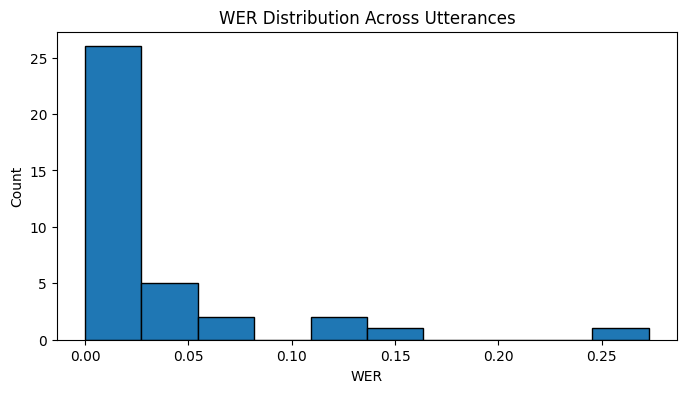

In [ ]:
# Visualizing WER Histogram
plt.figure(figsize=(8,4))
plt.hist(wer_df["wer"], bins=10, edgecolor="black")
plt.xlabel("WER")
plt.ylabel("Count")
plt.title("WER Distribution Across Utterances")
plt.show()

### **Observations**
- The histogram is **heavily right skewed**, with the majority clustered at zero.
- Only **one utterance** crosses 0.25 WER, indicating an isolated higher error case.
- Overall, the distribution confirmss that Whisper's transcription quality for this dataset is **consistently high and stable**.

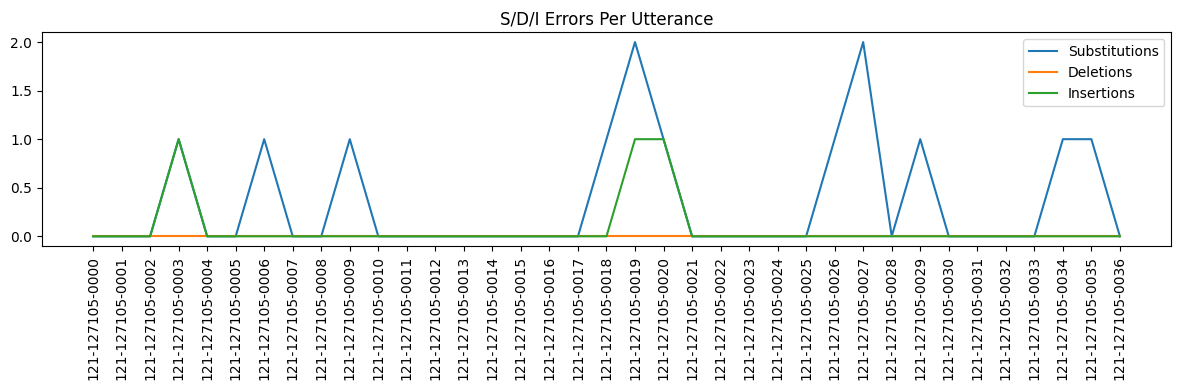

utt_id                                          reference  \
19  121-127105-0019  MISSUS GRIFFIN HOWEVER EXPRESSED THE NEED FOR ...   
9   121-127105-0009               SHE HAS BEEN DEAD THESE TWENTY YEARS   
18  121-127105-0018    CRIED THE LADIES WHOSE DEPARTURE HAD BEEN FIXED   
3   121-127105-0003  THERE WAS A UNANIMOUS GROAN AT THIS AND MUCH R...   
6   121-127105-0006  THE OTHERS RESENTED POSTPONEMENT BUT IT WAS JU...   

                                           hypothesis       wer  \
19  This is Griffin however, express the need for ...  0.272727   
9                   She has been dead these 20 years.  0.142857   
18     Cry the ladies whose departure had been fixed.  0.125000   
3   There was a unanimous groan at this, and much ...  0.111111   
6   The others resented postponement, but it was j...  0.076923   

    substitutions  deletions  insertions  hits  num_ref_words  
19              2          0           1     9             11  
9               1          0           0     6              7  
18              1          0           0     7              8  
3               1          0           1    17             18  
6               1          0           0    12             13

In [ ]:
# Visualizing S/D/I Counts Per Utterance
plt.figure(figsize=(12, 4))
plt.plot(wer_df["utt_id"], wer_df["substitutions"], label="Substitutions")
plt.plot(wer_df["utt_id"], wer_df["deletions"], label="Deletions")
plt.plot(wer_df["utt_id"], wer_df["insertions"], label="Insertions")
plt.xticks(rotation=90)
plt.legend()
plt.title("S/D/I Errors Per Utterance")
plt.tight_layout()
plt.show()

# Examining a Few Utterances with Highest WER
worst_cases = wer_df.sort_values("wer", ascending=False).head(5)
worst_cases

### **S/D/I Error Visualization Across Utterances**

- I plotted the **substitutions**, **deletions**, and **insertions** for every utterance to understand how Whisper's errors are distributed.

### **Observations**
- Substitutions are the most frequent error type, usually caused by **minor lexical mismatches** (e.g., *twenty -> 20*).
- Insertions happen rarely and usually due to Whisper adding small connecting words.
- The highest WER (~0.27) occurred when Whisper paraphrased *"MISSUS GRIFFIN HOWEVER"* as *"This is Griffin however"*.
- Other cases show small substitutions such as number words (*twenty -> 20*) or reordering.

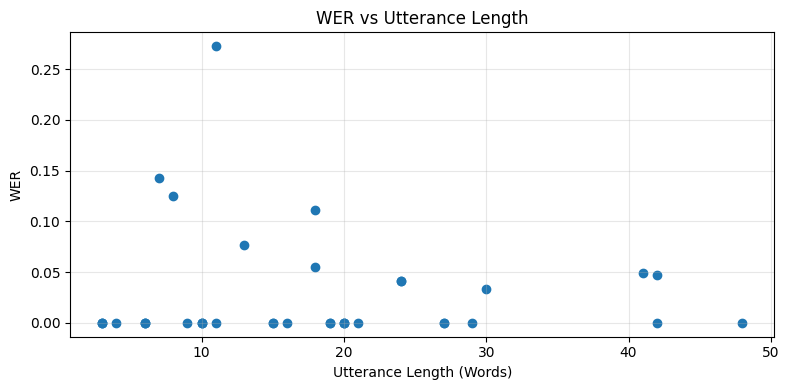

In [ ]:
# Visualizing WER vs Utterance Length
plt.figure(figsize=(8,4))
plt.scatter(wer_df["num_ref_words"], wer_df["wer"])
plt.xlabel("Utterance Length (Words)")
plt.ylabel("WER")
plt.title("WER vs Utterance Length")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **WER vs. Utterance Length**

- I created a scatter plot comparing each utterance's **reference word count** with its **WER score**.

### **Observations**
- There is **no clear correlation** between utterance length and WER.
- Many **long utterances** achieve **WER = 0.0**.
- The **highest WER values** occur in shorter/medium utterances, indicating errors come from **specific word substitutions**, not length.
- Overall, Whisper remains **stable across varying utterance lengths**.

In [ ]:
# Normalizing for overall WER & CER
clean_refs = [transform(r) for r in references]
clean_hyps = [transform(h) for h in hypotheses]

overall_wer = wer(clean_refs, clean_hyps)
overall_cer = cer(clean_refs, clean_hyps)

print("Overall WER:", overall_wer)
print("Overall CER:", overall_cer)

print("\nWER Summary Stats:")
print(wer_df["wer"].describe())

Overall WER: 0.024427480916030534
Overall CER: 0.012874251497005988

WER Summary Stats:
count    37.000000
mean      0.026952
std       0.056302
min       0.000000
25%       0.000000
50%       0.000000
75%       0.041667
max       0.272727
Name: wer, dtype: float64


### **Overall WER & CER Evaluation**

- After normalizing both reference and Whisper transcripts, I computed **overall Word Error Rate (WER)** and **Character Error Rate (CER)** across all 37 utterances.
- The scores obtained were:
  - **Overall WER:** 0.0244 (~ **2.44%**)
  - **Overall CER:** 0.0129 (~ **1.29%**)

### **Statistical Summary (WER Across 37 Utterances)**  
- **Mean WER:** 0.02695  
- **Median WER:** 0.00000  
- **Std. deviation:** 0.05630  
- **Min WER:** 0.00  
- **Max WER:** 0.2727  
- **75% of utterances have WER <= 0.0417**

### **Observations**
- Whisper performs good on the dataset, with **most utterances having zero errors**.
- The **very low CER (1.29%)** reinforces that character level deviations are rare, errors mostly come from whole, word substitutions rather than spelling variations.
- The **mean WER (2.7%)** is slightly higher than the overall WER because a few utterances contain small but noticeable errors (ex- 1-2 substitutions or insertions), which increase variance.
- The **median WER = 0** indicates that:  
  - **At least half of all utterances are transcribed perfectly.**
- The **max WER = 0.2727** corresponds to the specific difficult utterance identified earlier.
- The **distribution is highly skewed toward zero**, showing that Whisper's mistakes are rare and isolated.

---

# Reflection

This was my first time working with audio data, and it turned out to be a very helpful learning experience. I understood how raw audio connects to text through Whisper and how important preprocessing is for getting meaningful WER and CER results. Normalization, cleaning, and small text decisions actually change the accuracy, which made me appreciate the role of each step. I also reinforced older concepts like tokenization and feature extraction, but now in the context of speech. Overall, this assignment helped me understand the full picture; from audio to transcription to evaluation.
